### MODELO DE CLASSIFICAÇÃO PARA DETECTAR CANDIDATOS DO ENEM COMO NOTA ACIMA DE 600


# Importando bibliotecas e selecionando os dados de interesse


ENTENDENDO O NÉGOCIO

In [2]:
# Importando libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV, learning_curve,LeaveOneOut
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder,OrdinalEncoder,QuantileTransformer,LabelEncoder
from sklearn.feature_selection import f_classif, chi2
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, roc_auc_score, log_loss
from boruta import BorutaPy
import warnings
warnings.filterwarnings('ignore')

In [2]:


microdados_enem_19 = pd.read_csv(r"D:\EXPERIMENTOS DATA SCIENCE E GIS old\MICRODADOS_ENEM_2019.csv",encoding='iso-8859-1', sep=';')
microdados_enem_19.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001004627,2019,1506807,Santarém,15,PA,21,M,1,3,...,A,A,A,C,B,A,D,A,B,A
1,190001004628,2019,1504059,Mãe do Rio,15,PA,16,F,1,3,...,A,A,A,B,B,A,B,A,A,A
2,190001004629,2019,1505502,Paragominas,15,PA,18,F,1,1,...,B,A,A,D,B,B,D,A,C,B
3,190001004630,2019,1507706,São Sebastião da Boa Vista,15,PA,23,M,0,3,...,A,A,A,C,A,A,D,A,A,A
4,190001004631,2019,1503903,Juruti,15,PA,23,M,1,3,...,A,A,A,B,A,A,D,A,A,A


In [3]:
microdados_enem_19.shape

(5095270, 136)

In [4]:
dados_de_interesse = microdados_enem_19.loc[(microdados_enem_19["TP_ST_CONCLUSAO"] == 2)&(microdados_enem_19["TP_SIT_FUNC_ESC"] == 1)]

In [5]:
dados_de_interesse.shape

(1144363, 136)

In [6]:
lista_sul = ["RS","SC","PR"]
#lista_sul = [] 
#for x in microdados_enem_19["SG_UF_RESIDENCIA"]:
#    lista_sul.append(x)

In [7]:
# Pegando as notas dos alunos que estão concluindo o ensino médio
dados_de_interesse = microdados_enem_19.loc[(microdados_enem_19["TP_ST_CONCLUSAO"] == 2)&(microdados_enem_19["TP_SIT_FUNC_ESC"] == 1)&(microdados_enem_19.SG_UF_RESIDENCIA.isin(lista_sul))]

In [8]:
dados_de_interesse.shape

(133300, 136)

In [9]:
dados_de_interesse = dados_de_interesse.loc[(dados_de_interesse["NU_NOTA_CN"] != 0) & (dados_de_interesse["NU_NOTA_CH"] != 0) & (dados_de_interesse["NU_NOTA_LC"] != 0) & (dados_de_interesse["NU_NOTA_MT"] != 0) & (dados_de_interesse["NU_NOTA_REDACAO"] != 0) ]

Abaixo criei uma coluna contendo as médias das notas de todas as matérias. Usarei isso para criar o target

In [10]:
dados_de_interesse["MEDIAS"] = (dados_de_interesse["NU_NOTA_CN"] + dados_de_interesse["NU_NOTA_CH"] + dados_de_interesse["NU_NOTA_LC"] + dados_de_interesse["NU_NOTA_MT"]+dados_de_interesse["NU_NOTA_REDACAO"])/5

In [11]:
dados_de_interesse["MEDIAS"].describe()

count    107553.000000
mean        540.254202
std          74.804937
min         320.180000
25%         485.540000
50%         534.660000
75%         590.620000
max         821.960000
Name: MEDIAS, dtype: float64

In [399]:
dados_de_interesse["MEDIAS"].median()

537.8599999999999

In [12]:
dados_de_interesse.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,MEDIAS
5545,190001010172,2019,4208203,Itajaí,42,SC,17,M,1,3,...,A,A,B,A,A,B,A,A,A,NaN
32968,190001037596,2019,4314209,Pedro Osório,43,RS,18,F,1,3,...,A,A,B,A,A,B,A,A,A,540.74
59150,190001063779,2019,4200606,Águas Mornas,42,SC,22,F,1,5,...,A,A,B,A,B,B,A,A,B,NaN
196298,190001200931,2019,4119905,Ponta Grossa,41,PR,18,F,1,1,...,A,B,B,B,A,D,A,B,B,677.36
206265,190001210898,2019,4207502,Indaial,42,SC,17,F,1,1,...,A,A,B,A,A,B,A,A,B,NaN


In [13]:
dados_de_interesse.describe()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,...,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q005,MEDIAS
count,1.301250e+05,130125.0,1.301250e+05,130125.000000,130125.000000,130125.000000,130125.000000,130125.000000,1.259480e+05,125948.000000,...,130125.000000,112812.0,112812.000000,112812.000000,112812.000000,112812.000000,112812.000000,112812.000000,130125.000000,107553.000000
mean,1.900036e+11,2019.0,4.206502e+06,41.951116,17.931896,0.998171,1.457030,1.035973,4.169827e+06,41.579223,...,0.431139,1.0,128.367018,127.090558,119.899124,127.671879,97.665497,600.694075,3.775931,540.254202
std,1.353617e+06,0.0,8.623288e+04,0.859134,2.252720,0.266786,0.880179,0.237610,2.984970e+05,2.990730,...,0.495237,0.0,22.044408,35.393092,32.968190,27.915839,54.842594,145.207082,1.181832,74.804937
min,1.900010e+11,2019.0,4.100103e+06,41.000000,1.000000,0.000000,0.000000,0.000000,1.100015e+06,11.000000,...,0.000000,1.0,0.000000,40.000000,0.000000,0.000000,0.000000,40.000000,1.000000,320.180000
25%,1.900024e+11,2019.0,4.114203e+06,41.000000,17.000000,1.000000,1.000000,1.000000,4.110706e+06,41.000000,...,0.000000,1.0,120.000000,120.000000,100.000000,120.000000,60.000000,520.000000,3.000000,485.540000
50%,1.900037e+11,2019.0,4.206603e+06,42.000000,18.000000,1.000000,1.000000,1.000000,4.205407e+06,42.000000,...,0.000000,1.0,120.000000,120.000000,120.000000,120.000000,100.000000,600.000000,4.000000,534.660000
75%,1.900048e+11,2019.0,4.307609e+06,43.000000,18.000000,1.000000,2.000000,1.000000,4.309209e+06,43.000000,...,1.000000,1.0,140.000000,140.000000,140.000000,140.000000,140.000000,680.000000,4.000000,590.620000
max,1.900061e+11,2019.0,4.323804e+06,43.000000,72.000000,4.000000,5.000000,4.000000,5.300108e+06,53.000000,...,1.000000,1.0,200.000000,200.000000,200.000000,200.000000,200.000000,980.000000,20.000000,821.960000


VERIFICANDO OS NULOS

In [14]:
(dados_de_interesse.isnull().sum()/dados_de_interesse.isnull().shape[0])*100

NU_INSCRICAO                0.000000
NU_ANO                      0.000000
CO_MUNICIPIO_RESIDENCIA     0.000000
NO_MUNICIPIO_RESIDENCIA     0.000000
CO_UF_RESIDENCIA            0.000000
                             ...    
Q022                        0.000000
Q023                        0.000000
Q024                        0.000000
Q025                        0.000000
MEDIAS                     17.346398
Length: 137, dtype: float64

In [15]:
#Como os nulos estão na variável target nós vamos dropa-los

In [16]:
dados_de_interesse.dropna(inplace=True)

VERIFICANDO  LINHAS DUPLICADAS

In [17]:
print(f"There're  {dados_de_interesse.duplicated().sum()} duplicated rows")

There're  0 duplicated rows


In [18]:
#lista_metropoles = ["3550308","3304557","3205309","3106200","3509502"]

In [19]:
#dados_de_interesse.groupby("APROVADO").mean()

In [422]:
#dados_de_interesse['APROVADO'] , media_bins = pd.cut(dados_de_interesse['MEDIAS'], 5 ,labels=[1,2,3,4,5], retbins=True)

AGORA VOU CRIAR O TARGET, QUE CONSISTE NO QUANTIL COM AS NOTAS MAIS ALTAS (CONTÉM CERCA DOS 20% ALUNOS COM NOTAS MAIS ALTAS)

In [423]:

aux = []

for index,row in dados_de_interesse.iterrows():
    if row["MEDIAS"] > 500:
        aux.append(1)
    else:
        aux.append(0)
        
dados_de_interesse["APROVADO"] = aux

In [424]:
dados_de_interesse.shape

(100898, 138)

In [425]:
dados_de_interesse.loc[dados_de_interesse["MEDIAS"] > 540]

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,MEDIAS,APROVADO
32968,190001037596,2019,4314209,Pedro Osório,43,RS,18,F,1,3,...,A,B,A,A,B,A,A,A,540.74,1
196298,190001200931,2019,4119905,Ponta Grossa,41,PR,18,F,1,1,...,B,B,B,A,D,A,B,B,677.36,1
679677,190001684321,2019,4211900,Palhoça,42,SC,19,F,1,1,...,B,C,A,B,C,B,C,B,710.52,1
679684,190001684328,2019,4216701,São José do Cedro,42,SC,17,F,1,1,...,A,B,A,A,B,A,A,B,584.62,1
679700,190001684344,2019,4204004,Catanduvas,42,SC,18,F,1,1,...,A,B,A,A,A,A,A,B,591.84,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094515,190006119142,2019,4322707,Vera Cruz,43,RS,18,F,1,1,...,B,C,B,A,D,A,B,B,592.54,1
5094516,190006119143,2019,4322509,Vacaria,43,RS,18,F,1,3,...,B,B,B,A,C,A,B,B,549.82,1
5094522,190006119149,2019,4306908,Encruzilhada do Sul,43,RS,17,M,1,1,...,B,D,A,B,D,B,B,B,582.72,1
5094537,190006119164,2019,4321204,Taquara,43,RS,17,F,1,2,...,A,B,A,A,C,A,A,B,581.44,1


In [426]:
check = dados_de_interesse.loc[dados_de_interesse["APROVADO"] == 1]

In [427]:
check.groupby("NO_MUNICIPIO_RESIDENCIA").count().sort_values(by = 'NU_INSCRICAO')
    

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,MEDIAS,APROVADO
NO_MUNICIPIO_RESIDENCIA,,,,,,,,,,,,,,,,,,,,,
São Manoel do Paraná,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Linha Nova,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Forquetinha,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Lajeado Grande,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Capão Alto,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pelotas,1004,1004,1004,1004,1004,1004,1004,1004,1004,1004,...,1004,1004,1004,1004,1004,1004,1004,1004,1004,1004
Joinville,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,...,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528
Florianópolis,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735,...,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735


In [428]:
#dados_de_interesse["APROVADO"] = pd.qcut(dados_de_interesse['MEDIAS'], q=5,labels=[1,2,3,4,5],duplicates = "drop")

In [429]:
#dados_de_interesse.groupby("APROVADO").mean()

In [430]:
dados_de_interesse.groupby("APROVADO").count()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,MEDIAS
APROVADO,,,,,,,,,,,,,,,,,,,,,
0,30781,30781,30781,30781,30781,30781,30781,30781,30781,30781,...,30781,30781,30781,30781,30781,30781,30781,30781,30781,30781
1,70117,70117,70117,70117,70117,70117,70117,70117,70117,70117,...,70117,70117,70117,70117,70117,70117,70117,70117,70117,70117


In [431]:
#selecionando as colunas de interesse
SELECIONADAS = dados_de_interesse.loc[:,["MEDIAS","CO_MUNICIPIO_RESIDENCIA","CO_ESCOLA","APROVADO","NU_IDADE","TP_SEXO","TP_ESTADO_CIVIL","TP_COR_RACA","TP_ESCOLA","TP_ENSINO","TP_DEPENDENCIA_ADM_ESC","TP_LOCALIZACAO_ESC","IN_DEFICIENCIA_FISICA","IN_DEFICIENCIA_MENTAL","Q001",
"Q002",
"Q003",
"Q004",
"Q005",
"Q006",
"Q024",
"Q025"]]

In [432]:
SELECIONADAS.to_csv("SELECIONADAS.csv")

# DATA CLEANING E SEPRAÇÃO DOS DATASETS

In [433]:
DADOS = pd.read_csv("SELECIONADAS.csv")
del DADOS["Unnamed: 0"]
DADOS

,MEDIAS,CO_MUNICIPIO_RESIDENCIA,CO_ESCOLA,APROVADO,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ESCOLA,TP_ENSINO,...,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025
0,540.74,4314209,14003724.0,1,18,F,1,3,2,1.0,...,0,0,C,C,A,A,5,C,A,A
1,677.36,4119905,21093040.0,1,18,F,1,1,2,1.0,...,0,0,F,E,D,C,3,K,B,B
2,503.08,4126306,35015325.0,1,17,M,1,1,2,1.0,...,0,0,E,E,A,C,3,C,A,B
3,469.08,4216008,42056322.0,0,17,M,1,1,2,1.0,...,0,0,B,C,A,A,4,C,B,B
4,710.52,4211900,42066670.0,1,19,F,1,1,2,1.0,...,0,0,H,E,F,D,3,J,C,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100893,525.50,4310603,43077595.0,1,16,F,1,1,2,1.0,...,0,0,C,F,D,D,4,I,B,B
100894,508.88,4301107,43016430.0,1,17,F,1,3,2,1.0,...,0,0,E,E,D,B,3,B,A,B
100895,519.92,4303103,43174116.0,1,18,F,1,2,2,1.0,...,0,0,H,F,B,B,3,H,B,B
100896,581.44,4321204,43152767.0,1,17,F,1,2,2,1.0,...,0,0,F,G,F,B,2,D,A,B


In [434]:
# Aqui filtrei as linhas sem informação referente as profissoes dos pais
#DADOS = DADOS.loc[(DADOS["Q003"] != "F") & (DADOS["Q004"] != 'F')]

In [435]:
CHECK = DADOS.loc[DADOS["APROVADO"] == 1 ]
CHECK["MEDIAS"].describe()

count    70117.000000
mean       579.790583
std         56.665226
min        500.020000
25%        533.660000
50%        569.500000
75%        616.300000
max        821.960000
Name: MEDIAS, dtype: float64

SEPARANDO OS DATASETS

In [436]:
# Fazendo separação em treino e teste, deixando 80% dos dados para treino e 20% para teste
df_train, df_test = train_test_split(DADOS, test_size=0.2, random_state=42)

In [437]:
df_train.groupby("TP_COR_RACA").count()

,MEDIAS,CO_MUNICIPIO_RESIDENCIA,CO_ESCOLA,APROVADO,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,...,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025
TP_COR_RACA,,,,,,,,,,,,,,,,,,,,,
0,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,...,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523
1,60497,60497,60497,60497,60497,60497,60497,60497,60497,60497,...,60497,60497,60497,60497,60497,60497,60497,60497,60497,60497
2,3216,3216,3216,3216,3216,3216,3216,3216,3216,3216,...,3216,3216,3216,3216,3216,3216,3216,3216,3216,3216
3,14439,14439,14439,14439,14439,14439,14439,14439,14439,14439,...,14439,14439,14439,14439,14439,14439,14439,14439,14439,14439
4,915,915,915,915,915,915,915,915,915,915,...,915,915,915,915,915,915,915,915,915,915
5,128,128,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128


In [438]:
df_train.groupby("APROVADO").mean()

,MEDIAS,CO_MUNICIPIO_RESIDENCIA,CO_ESCOLA,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,Q005
APROVADO,,,,,,,,,,,,,
0,459.563095,4.201241e+06,4.197818e+07,17.846204,1.000325,1.567210,2.026364,1.003047,2.077670,1.042369,0.001666,0.001016,3.863996
1,579.918943,4.210443e+06,4.208618e+07,17.582574,0.992514,1.354094,2.180015,1.001622,2.419565,1.030534,0.000446,0.000000,3.719114


In [439]:
df_train

,MEDIAS,CO_MUNICIPIO_RESIDENCIA,CO_ESCOLA,APROVADO,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ESCOLA,TP_ENSINO,...,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025
98757,566.68,4314902,43002803.0,1,18,M,1,1,2,1.0,...,0,0,H,E,F,D,4,C,B,B
81351,474.72,4309654,43019358.0,0,18,F,1,1,2,1.0,...,0,0,F,F,F,E,3,L,C,B
89684,662.62,4210407,42076978.0,1,17,M,1,1,2,1.0,...,0,0,F,G,D,D,5,O,B,B
94144,517.26,4309209,43069126.0,1,17,M,1,1,2,1.0,...,0,0,E,E,C,B,4,C,A,B
65343,574.28,4119905,41157044.0,1,17,F,1,1,2,1.0,...,0,0,C,B,A,A,2,F,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,679.00,4314902,43105238.0,1,17,M,1,1,2,1.0,...,0,0,E,E,B,B,3,C,A,B
54886,492.18,4113700,41031970.0,0,18,M,1,1,2,1.0,...,0,0,D,F,C,D,5,G,A,B
76820,585.92,4305108,43041639.0,1,18,M,1,1,3,1.0,...,0,0,F,G,E,D,4,O,C,B
860,605.78,4314902,43107494.0,1,18,F,1,1,3,1.0,...,0,0,E,D,E,F,3,P,B,B


In [440]:
target = 'APROVADO'
disc_cols = ["TP_SEXO","TP_ESTADO_CIVIL","TP_COR_RACA","TP_ESCOLA","TP_ENSINO","TP_DEPENDENCIA_ADM_ESC","TP_LOCALIZACAO_ESC","TP_LOCALIZACAO_ESC","IN_DEFICIENCIA_MENTAL","IN_DEFICIENCIA_FISICA","Q001","Q002","Q003","Q004","Q025"]
cont_cols = ["POPULAÇÃO ESTIMADA",'NU_IDADE',"Q005","Q006","Q024"]

In [441]:
def EDA(df, disc_cols, cont_cols, target):
    for col in df.columns:
        if col in disc_cols:
            fig, ax = plt.subplots(1, 2, figsize=(15, 6))
            fig.suptitle(f'Variável {col}', fontsize=20, fontweight='bold', y=1)
            sns.countplot(x=col, data=df, ax=ax[0], ec='black')
            ax[0].grid(axis='y')
            ax[0].set_title(f'Distribuição de {col}')

            sns.barplot(x=col, y=target, data=df, ax=ax[1], ec='black', ci=None)
            ax[1].grid(axis='y')
            ax[1].set_title(f'{target} em função de {col}')
            plt.show()

        elif col in cont_cols:
            fig, ax = plt.subplots(1, 2, figsize=(15, 6))
            fig.suptitle(f'Variável {col}', fontsize=20, fontweight='bold', y=1)
            sns.histplot(x=col, hue=target, data=df, ax=ax[0])
            ax[0].set_title(f'Distribuição de {col}')

            sns.boxplot(x=target, y=col, data=df, ax=ax[1])
            ax[1].set_title(f'Boxplot de {col} em função de {target}')
            plt.show()

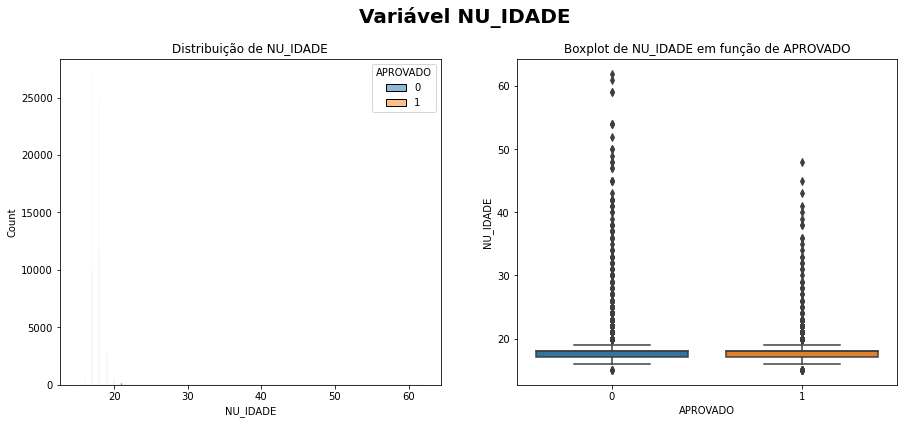

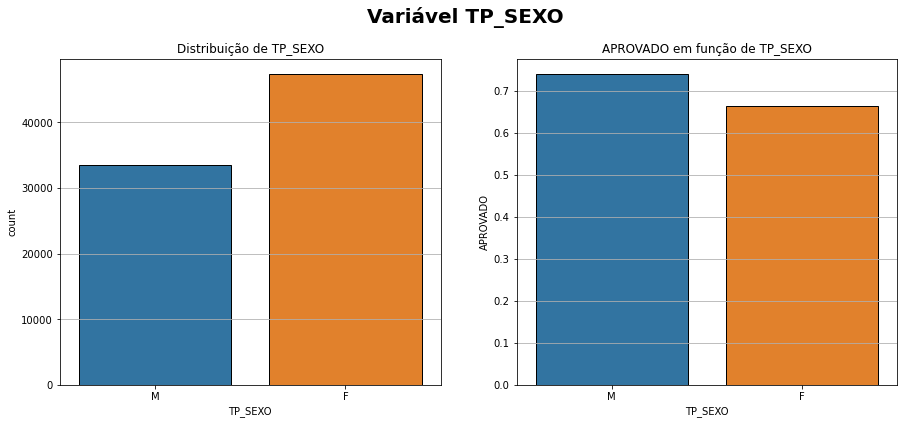

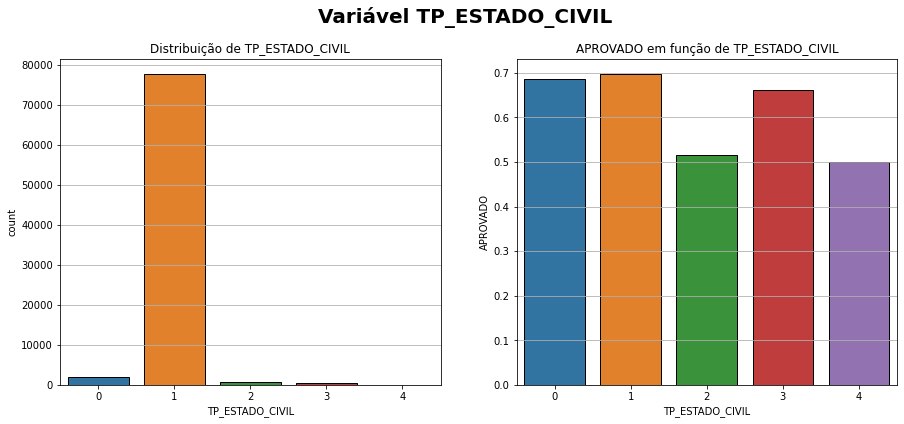

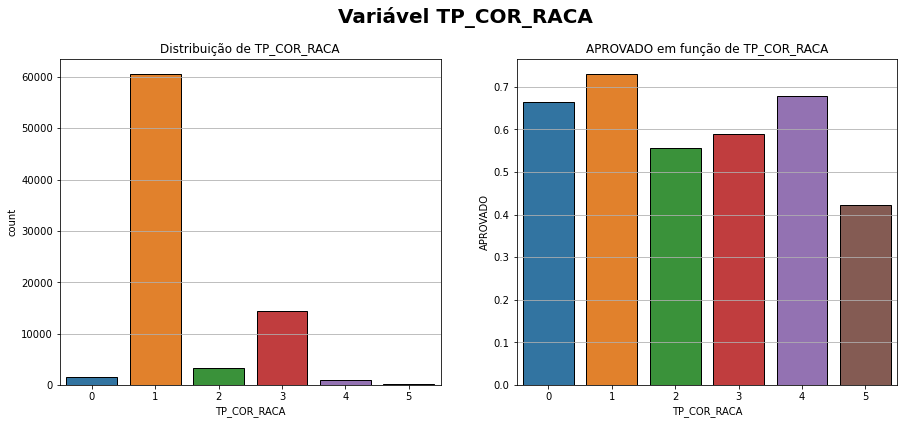

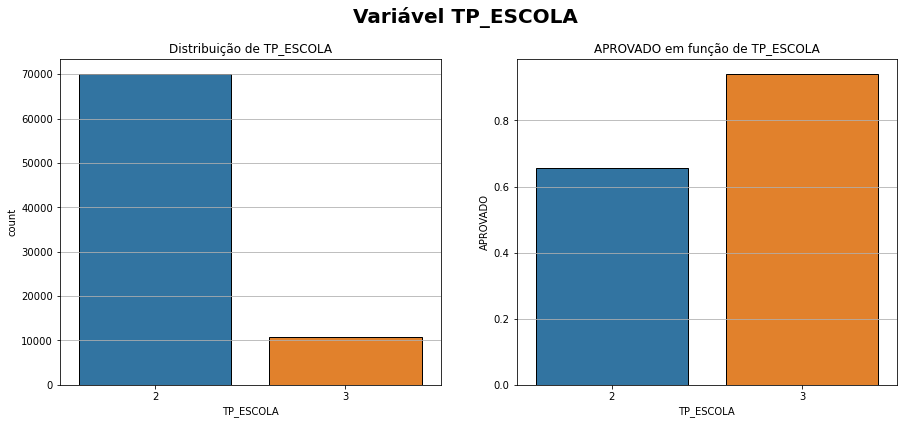

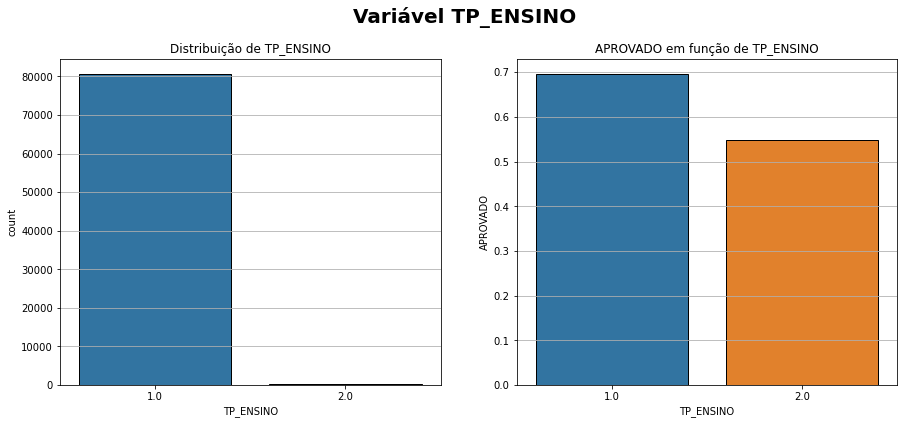

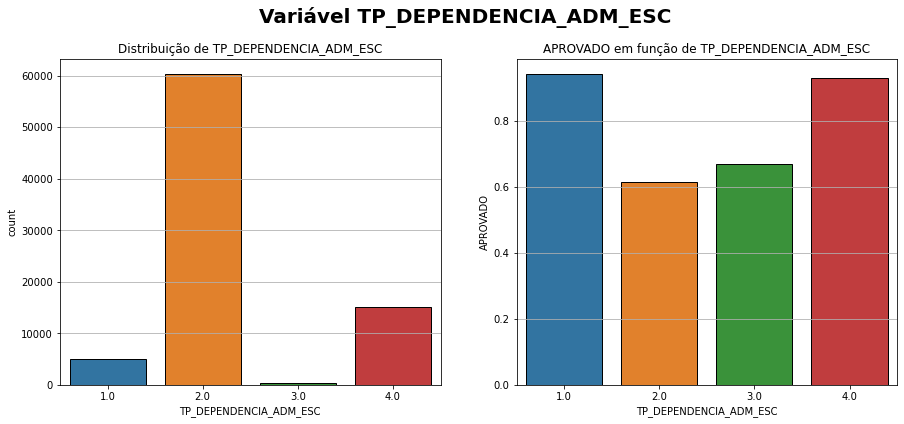

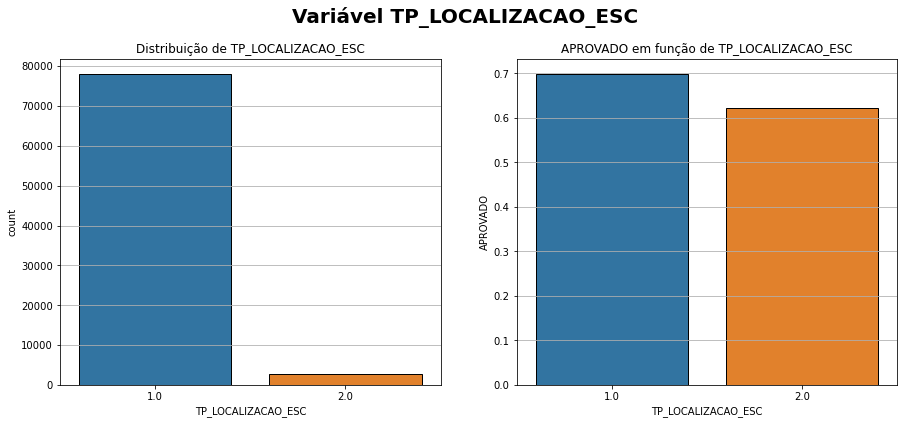

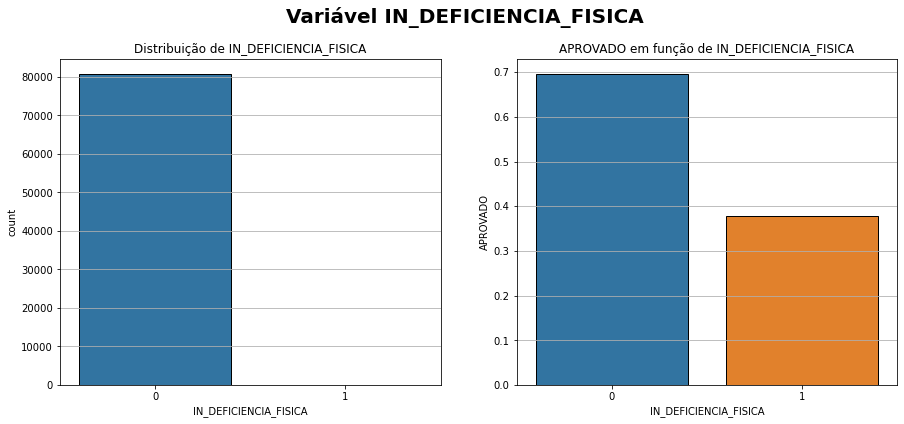

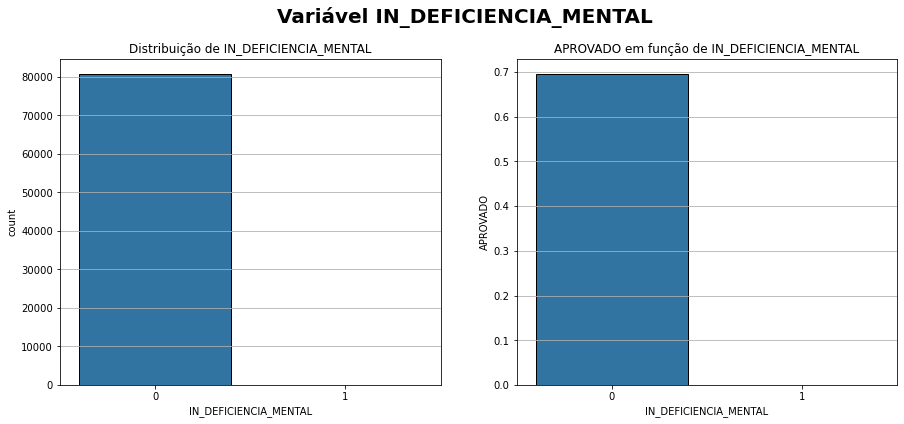

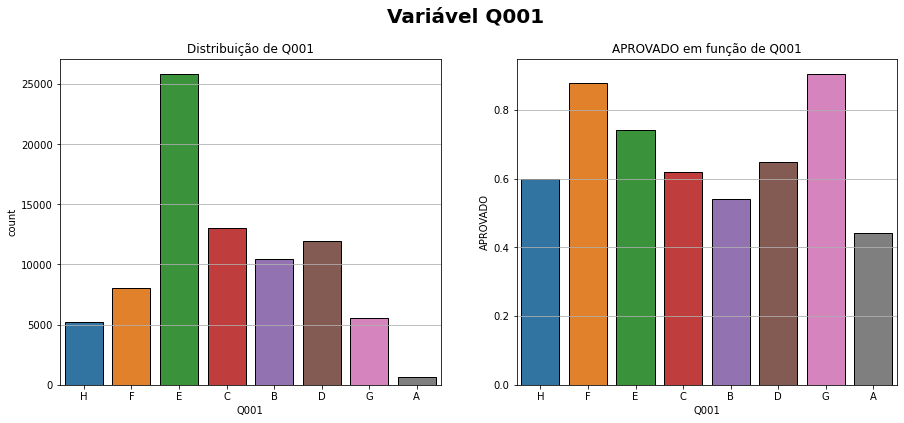

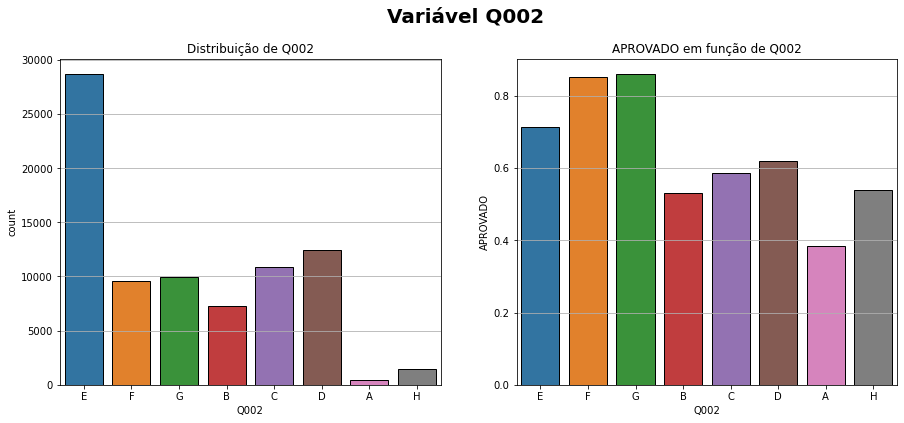

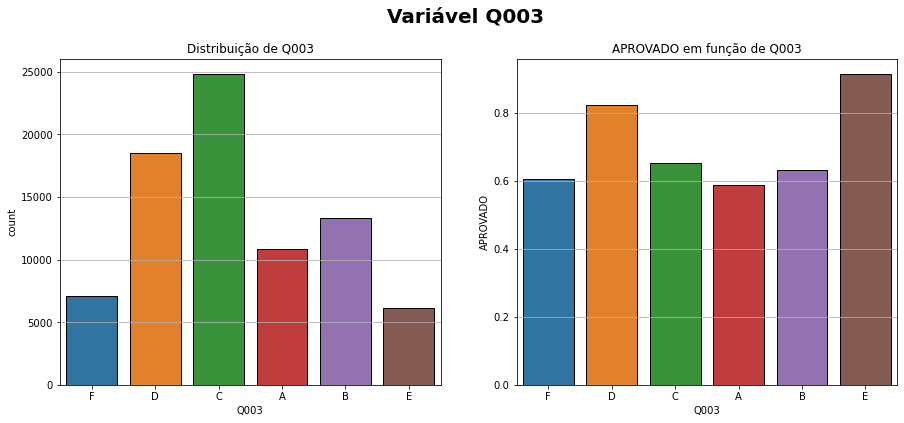

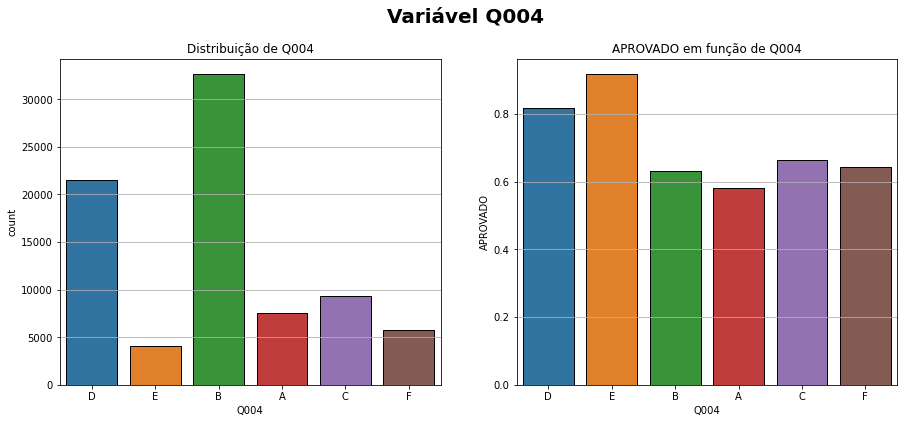

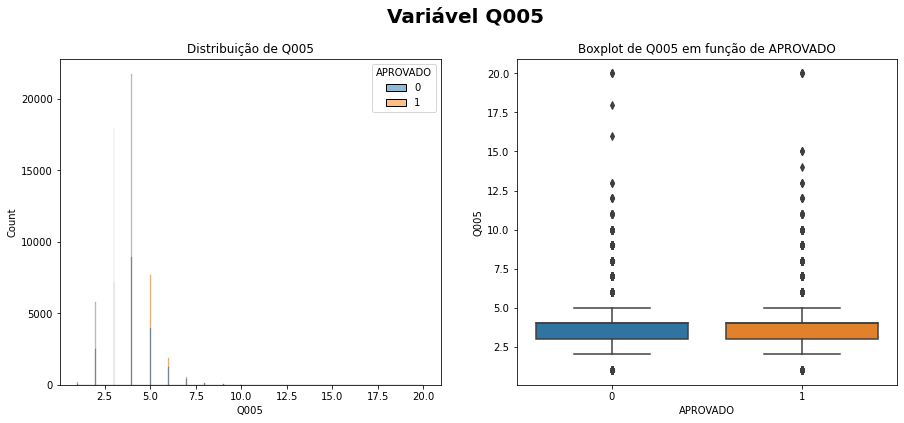

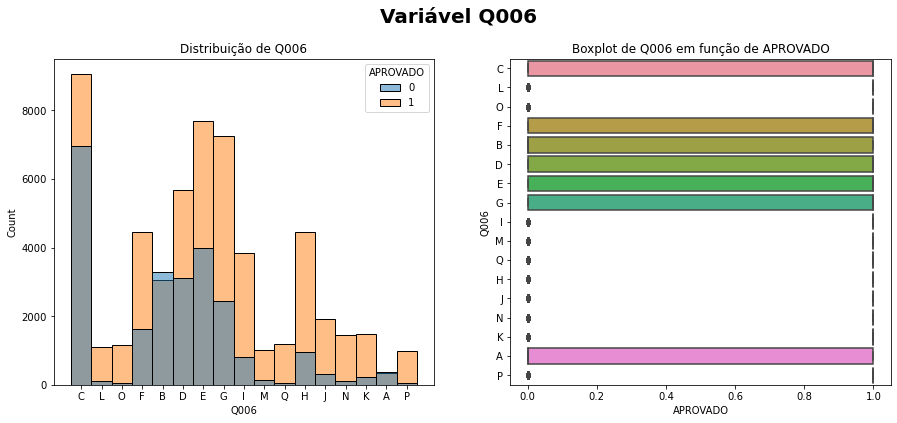

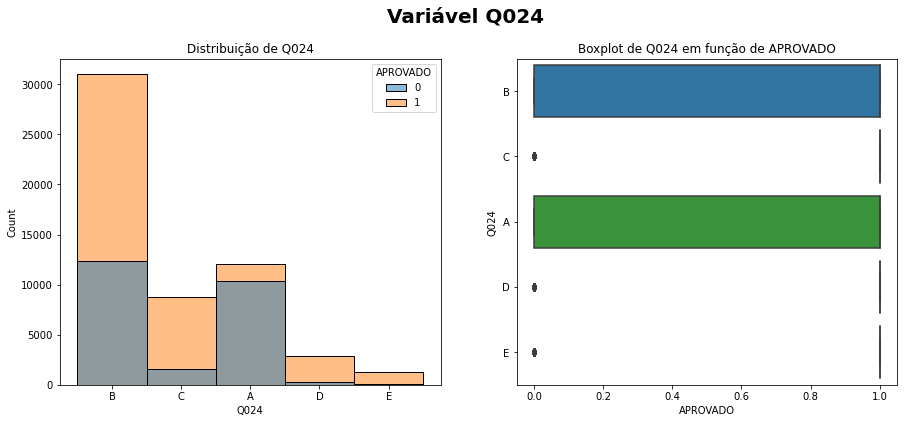

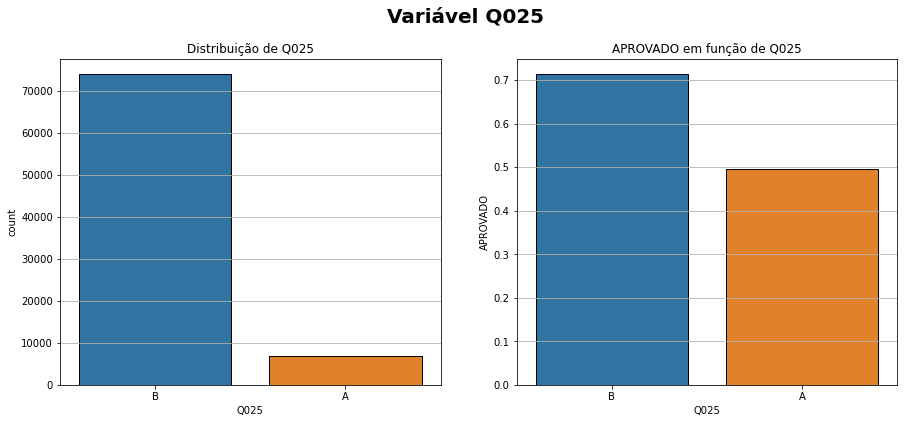

In [442]:
EDA(df_train, disc_cols, cont_cols, target)

In [443]:
df_train

,MEDIAS,CO_MUNICIPIO_RESIDENCIA,CO_ESCOLA,APROVADO,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ESCOLA,TP_ENSINO,...,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025
98757,566.68,4314902,43002803.0,1,18,M,1,1,2,1.0,...,0,0,H,E,F,D,4,C,B,B
81351,474.72,4309654,43019358.0,0,18,F,1,1,2,1.0,...,0,0,F,F,F,E,3,L,C,B
89684,662.62,4210407,42076978.0,1,17,M,1,1,2,1.0,...,0,0,F,G,D,D,5,O,B,B
94144,517.26,4309209,43069126.0,1,17,M,1,1,2,1.0,...,0,0,E,E,C,B,4,C,A,B
65343,574.28,4119905,41157044.0,1,17,F,1,1,2,1.0,...,0,0,C,B,A,A,2,F,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,679.00,4314902,43105238.0,1,17,M,1,1,2,1.0,...,0,0,E,E,B,B,3,C,A,B
54886,492.18,4113700,41031970.0,0,18,M,1,1,2,1.0,...,0,0,D,F,C,D,5,G,A,B
76820,585.92,4305108,43041639.0,1,18,M,1,1,3,1.0,...,0,0,F,G,E,D,4,O,C,B
860,605.78,4314902,43107494.0,1,18,F,1,1,3,1.0,...,0,0,E,D,E,F,3,P,B,B


In [444]:
target = ['APROVADO']
cat_cols = ["TP_SEXO","TP_ESTADO_CIVIL","TP_ESCOLA","TP_ENSINO","TP_DEPENDENCIA_ADM_ESC","TP_LOCALIZACAO_ESC","IN_DEFICIENCIA_MENTAL","IN_DEFICIENCIA_FISICA","Q001","Q002","Q003","Q004","Q025","Q024","Q006"]
num_cols = ['NU_IDADE',"Q005"]

df_train[num_cols+target].corr()['APROVADO']

NU_IDADE   -0.109715
Q005       -0.058634
APROVADO    1.000000
Name: APROVADO, dtype: float64

In [445]:
def cramer_v(df, cat_cols):
    df=df
    cat_cols=cat_cols
    # dicionário para guardar o cramer V de cada coluna em relação às demais
    dict_cramer = {}
    # primeiro for loop é para percorrer as colunas categóricas
    for cat in cat_cols:
        # lista para guardar os valores obtidos de cramer v a cada coluna 
        cramer_v_list = []
        # segundo for loop é para percorrer para uma variável categórica todas as colunas do dataframe
        for cat_ in cat_cols:
            # gerando a tabela de contingência
            df_cross = pd.crosstab(df[cat], df[cat_])
            # extraindo o valor de chi2
            chi2_teste, p, df_, arr = stats.chi2_contingency(df_cross)
            # calculando o número de linhas
            r = len(df_cross)
            # calculando o número de colunas
            c = len(df_cross.columns)
            # calculando a soma dos elementos das células
            n = df_cross.to_numpy().sum()
            # calculando o V de cramer
            V = np.sqrt((chi2_teste/(n*(np.min([r,c]) -1))))
            # appendando o resultado na lista
            cramer_v_list.append(V)
        # salvando para um elemento do dicionário a lista contendo os V de cramer correspondentes
        dict_cramer[cat] = cramer_v_list
        # criando dataframe a partir do dicionário
        df_v_cramer = pd.DataFrame(dict_cramer)
        # adicionando o índice com o nome das variáveis
        df_v_cramer.index=cat_cols
    return df_v_cramer

In [446]:
# V de Cramer
cramer_v(df_train, cat_cols+target)['APROVADO']

TP_SEXO                   0.081050
TP_ESTADO_CIVIL           0.034998
TP_ESCOLA                 0.208178
TP_ENSINO                 0.014181
TP_DEPENDENCIA_ADM_ESC    0.298256
TP_LOCALIZACAO_ESC        0.029930
IN_DEFICIENCIA_MENTAL     0.025807
IN_DEFICIENCIA_FISICA     0.019178
Q001                      0.241501
Q002                      0.240632
Q003                      0.225682
Q004                      0.213686
Q025                      0.131895
Q024                      0.247249
Q006                      0.280903
APROVADO                  0.999971
Name: APROVADO, dtype: float64

# FEATURE Engineering

In [447]:
df_train

,MEDIAS,CO_MUNICIPIO_RESIDENCIA,CO_ESCOLA,APROVADO,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ESCOLA,TP_ENSINO,...,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025
98757,566.68,4314902,43002803.0,1,18,M,1,1,2,1.0,...,0,0,H,E,F,D,4,C,B,B
81351,474.72,4309654,43019358.0,0,18,F,1,1,2,1.0,...,0,0,F,F,F,E,3,L,C,B
89684,662.62,4210407,42076978.0,1,17,M,1,1,2,1.0,...,0,0,F,G,D,D,5,O,B,B
94144,517.26,4309209,43069126.0,1,17,M,1,1,2,1.0,...,0,0,E,E,C,B,4,C,A,B
65343,574.28,4119905,41157044.0,1,17,F,1,1,2,1.0,...,0,0,C,B,A,A,2,F,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,679.00,4314902,43105238.0,1,17,M,1,1,2,1.0,...,0,0,E,E,B,B,3,C,A,B
54886,492.18,4113700,41031970.0,0,18,M,1,1,2,1.0,...,0,0,D,F,C,D,5,G,A,B
76820,585.92,4305108,43041639.0,1,18,M,1,1,3,1.0,...,0,0,F,G,E,D,4,O,C,B
860,605.78,4314902,43107494.0,1,18,F,1,1,3,1.0,...,0,0,E,D,E,F,3,P,B,B


In [448]:
df_train.drop(["TP_COR_RACA"],axis = 1 , inplace = True)
df_test.drop(["TP_COR_RACA"],axis = 1 , inplace = True)

In [449]:
df_train.groupby("CO_ESCOLA").count().reset_index()

,CO_ESCOLA,MEDIAS,CO_MUNICIPIO_RESIDENCIA,APROVADO,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,...,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025
0,12011444.0,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,12020249.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,13026194.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,13026488.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,13037013.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4308,52015360.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4309,52035344.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4310,52092143.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4311,53001354.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [450]:
medias_escolas = df_train.groupby("CO_ESCOLA").mean().reset_index()
medias_escolas = medias_escolas[["CO_ESCOLA","MEDIAS"]]

In [451]:
medias_escolas

,CO_ESCOLA,MEDIAS
0,12011444.0,529.58
1,12020249.0,594.26
2,13026194.0,558.52
3,13026488.0,533.24
4,13037013.0,444.20
...,...,...
4308,52015360.0,495.88
4309,52035344.0,493.80
4310,52092143.0,515.84
4311,53001354.0,741.12


In [452]:
contagem_escolas = df_train.groupby("CO_ESCOLA").count().reset_index()
contagem_escolas = contagem_escolas[["CO_ESCOLA","MEDIAS"]]
contagem_escolas.rename(columns = {"MEDIAS":"QTD_ALUNOS"},inplace = True)

In [453]:
contagem_escolas

,CO_ESCOLA,QTD_ALUNOS
0,12011444.0,2
1,12020249.0,1
2,13026194.0,1
3,13026488.0,1
4,13037013.0,1
...,...,...
4308,52015360.0,1
4309,52035344.0,1
4310,52092143.0,1
4311,53001354.0,1


In [454]:
contagem_escolas =  contagem_escolas.merge(medias_escolas, left_on='CO_ESCOLA', right_on='CO_ESCOLA')

In [455]:
contagem_escolas

,CO_ESCOLA,QTD_ALUNOS,MEDIAS
0,12011444.0,2,529.58
1,12020249.0,1,594.26
2,13026194.0,1,558.52
3,13026488.0,1,533.24
4,13037013.0,1,444.20
...,...,...,...
4308,52015360.0,1,495.88
4309,52035344.0,1,493.80
4310,52092143.0,1,515.84
4311,53001354.0,1,741.12


In [456]:
contagem_escolas.corr(method="spearman")

,CO_ESCOLA,QTD_ALUNOS,MEDIAS
CO_ESCOLA,1.000000,0.090038,0.155948
QTD_ALUNOS,0.090038,1.000000,0.203600
MEDIAS,0.155948,0.203600,1.000000


In [457]:
import matplotlib.pyplot as plt

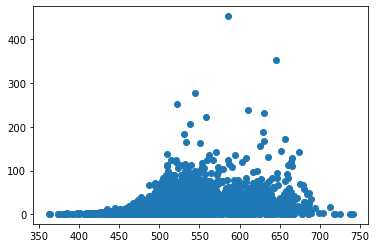

In [458]:
plt.scatter(contagem_escolas["MEDIAS"], contagem_escolas["QTD_ALUNOS"])

In [459]:
#escolas = df_test.groupby("CO_ESCOLA").median().reset_index()
#escolas = escolas[["CO_ESCOLA","MEDIAS"]]
#escolas.rename(columns = {"MEDIAS":"MEDIANA_ESCOLA"},inplace = True)
#df_test =  df_test.merge(escolas, left_on='CO_ESCOLA', right_on='CO_ESCOLA')

In [460]:
df_train = df_train.merge(contagem_escolas,on="CO_ESCOLA")
df_test = df_test.merge(contagem_escolas,on="CO_ESCOLA")

In [461]:
df_train

,MEDIAS_x,CO_MUNICIPIO_RESIDENCIA,CO_ESCOLA,APROVADO,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,...,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025,QTD_ALUNOS,MEDIAS_y
0,566.68,4314902,43002803.0,1,18,M,1,2,1.0,4.0,...,H,E,F,D,4,C,B,B,31,519.922581
1,474.10,4314902,43002803.0,0,19,M,1,2,1.0,4.0,...,H,B,B,B,5,C,A,B,31,519.922581
2,441.66,4314902,43002803.0,0,18,M,1,2,1.0,4.0,...,H,H,B,F,7,B,A,A,31,519.922581
3,492.34,4314902,43002803.0,0,19,F,1,2,1.0,4.0,...,B,B,C,B,3,C,A,B,31,519.922581
4,538.84,4314902,43002803.0,1,20,M,1,2,1.0,4.0,...,H,E,C,B,3,D,A,A,31,519.922581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80713,535.10,4318465,43138039.0,1,18,M,1,2,1.0,2.0,...,C,E,B,B,3,C,B,B,1,535.100000
80714,486.26,4128203,41118430.0,0,23,M,1,2,1.0,2.0,...,H,C,F,A,4,C,A,B,1,486.260000
80715,542.86,4117107,41001630.0,1,17,M,1,2,1.0,4.0,...,E,E,C,D,4,G,C,B,1,542.860000
80716,532.64,4301107,43016464.0,1,18,F,1,2,1.0,4.0,...,B,E,B,D,2,E,B,B,1,532.640000


In [462]:
del df_train["MEDIAS_x"]
del df_train["MEDIAS_y"]

In [463]:
del df_test["MEDIAS_x"]
del df_test["MEDIAS_y"]

In [464]:
df_train.drop("CO_ESCOLA",axis = 1 , inplace = True)

In [465]:
df_test.drop("CO_ESCOLA",axis = 1 , inplace = True)

In [466]:
#criar_faixa(df_train, "NU_IDADE" , "FAIXA_ETARIA")

In [467]:
#criar_faixa(df_test, "NU_IDADE" , "FAIXA_ETARIA")

AQUI FIZ O CRAMER V E A CORRELAÇÃO COM OS DADOS TRATADOS

In [468]:
# V de Cramer
cramer_v(df_train, cat_cols+target)['APROVADO']

TP_SEXO                   0.081050
TP_ESTADO_CIVIL           0.034998
TP_ESCOLA                 0.208178
TP_ENSINO                 0.014181
TP_DEPENDENCIA_ADM_ESC    0.298256
TP_LOCALIZACAO_ESC        0.029930
IN_DEFICIENCIA_MENTAL     0.025807
IN_DEFICIENCIA_FISICA     0.019178
Q001                      0.241501
Q002                      0.240632
Q003                      0.225682
Q004                      0.213686
Q025                      0.131895
Q024                      0.247249
Q006                      0.280903
APROVADO                  0.999971
Name: APROVADO, dtype: float64

In [469]:
df_train[num_cols+target].corr()['APROVADO']
     
  



NU_IDADE   -0.109715
Q005       -0.058634
APROVADO    1.000000
Name: APROVADO, dtype: float64

TRANSFORMANDO A VARIAVEL COR RAÇA EM BRANCO E NÃO BRANCO PARECE APRESENTAR RESULTADOS MELHORES


In [470]:
pop = pd.read_excel(r'C:\Users\eduar\OneDrive\Área de Trabalho\EXPERIMENTOS DATA SCIENCE E GIS\EDUCACAO\microdados_enem_2019\DADOS\POP2020_20210204.xls',header = 1)

In [471]:
pop

,UF,COD. UF,COD. MUNIC,NOME DO MUNICÍPIO,POPULAÇÃO ESTIMADA
0,RO,11,15,Alta Floresta D'Oeste,22728
1,RO,11,23,Ariquemes,109523
2,RO,11,31,Cabixi,5188
3,RO,11,49,Cacoal,85893
4,RO,11,56,Cerejeiras,16204
...,...,...,...,...,...
5565,GO,52,22005,Vianópolis,13977
5566,GO,52,22054,Vicentinópolis,8873
5567,GO,52,22203,Vila Boa,6312
5568,GO,52,22302,Vila Propício,5882


In [472]:
pop.dtypes

UF                    object
COD. UF                int64
COD. MUNIC             int64
NOME DO MUNICÍPIO     object
POPULAÇÃO ESTIMADA     int64
dtype: object

In [473]:
pop["COD. UF"]= pop["COD. UF"].astype("str")
pop["COD. MUNIC"]= pop["COD. MUNIC"].astype("str")

In [474]:
aux = []
for x in pop["COD. MUNIC"]:
    if len(x) == 2:
        aux.append("000{}".format(x))
    elif len(x) == 3:
        aux.append("00{}".format(x))
    elif len(x) == 4:
        aux.append("0{}".format(x))
    else:
        aux.append(x)
        

In [475]:
pop["codigo"] = pop["COD. UF"] + aux

In [476]:
pop

,UF,COD. UF,COD. MUNIC,NOME DO MUNICÍPIO,POPULAÇÃO ESTIMADA,codigo
0,RO,11,15,Alta Floresta D'Oeste,22728,1100015
1,RO,11,23,Ariquemes,109523,1100023
2,RO,11,31,Cabixi,5188,1100031
3,RO,11,49,Cacoal,85893,1100049
4,RO,11,56,Cerejeiras,16204,1100056
...,...,...,...,...,...,...
5565,GO,52,22005,Vianópolis,13977,5222005
5566,GO,52,22054,Vicentinópolis,8873,5222054
5567,GO,52,22203,Vila Boa,6312,5222203
5568,GO,52,22302,Vila Propício,5882,5222302


In [477]:
pop = pop.loc[pop.UF.isin(lista_sul)] 

In [478]:
import geopandas as gpd

In [479]:
cidades = gpd.read_file(r"D:\JOBS ATUAL\shps ibge\BR_Municipios_2020\BR_Municipios_2020.shp")

In [480]:
cidades = cidades.loc[cidades.SIGLA_UF.isin(lista_sul)] 

In [481]:
cidades.dtypes

CD_MUN        object
NM_MUN        object
SIGLA_UF      object
AREA_KM2     float64
geometry    geometry
dtype: object

In [482]:
pop

,UF,COD. UF,COD. MUNIC,NOME DO MUNICÍPIO,POPULAÇÃO ESTIMADA,codigo
3912,PR,41,103,Abatiá,7408,4100103
3913,PR,41,202,Adrianópolis,5857,4100202
3914,PR,41,301,Agudos do Sul,9470,4100301
3915,PR,41,400,Almirante Tamandaré,120041,4100400
3916,PR,41,459,Altamira do Paraná,1682,4100459
...,...,...,...,...,...,...
5098,RS,43,23606,Vista Alegre do Prata,1557,4323606
5099,RS,43,23705,Vista Gaúcha,2855,4323705
5100,RS,43,23754,Vitória das Missões,3092,4323754
5101,RS,43,23770,Westfália,3031,4323770


In [483]:
cidades

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
3912,4100103,Abatiá,PR,228.717,"POLYGON ((-50.22465 -23.22603, -50.22561 -23.2..."
3913,4100202,Adrianópolis,PR,1349.311,"POLYGON ((-48.99969 -24.63712, -48.99927 -24.6..."
3914,4100301,Agudos do Sul,PR,192.261,"POLYGON ((-49.30433 -25.94769, -49.30541 -25.9..."
3915,4100400,Almirante Tamandaré,PR,194.888,"POLYGON ((-49.28261 -25.22827, -49.28076 -25.2..."
3916,4100459,Altamira do Paraná,PR,386.945,"POLYGON ((-52.81511 -24.71726, -52.80995 -24.7..."
...,...,...,...,...,...
5098,4323606,Vista Alegre do Prata,RS,119.327,"POLYGON ((-51.76224 -28.77950, -51.76238 -28.7..."
5099,4323705,Vista Gaúcha,RS,90.022,"POLYGON ((-53.70785 -27.19948, -53.70824 -27.2..."
5100,4323754,Vitória das Missões,RS,258.312,"POLYGON ((-54.54098 -28.27137, -54.53284 -28.2..."
5101,4323770,Westfália,RS,63.665,"POLYGON ((-51.72745 -29.36941, -51.69108 -29.3..."


In [484]:
pop = pop.merge(cidades,left_on = "codigo", right_on = "CD_MUN" )
pop

,UF,COD. UF,COD. MUNIC,NOME DO MUNICÍPIO,POPULAÇÃO ESTIMADA,codigo,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,PR,41,103,Abatiá,7408,4100103,4100103,Abatiá,PR,228.717,"POLYGON ((-50.22465 -23.22603, -50.22561 -23.2..."
1,PR,41,202,Adrianópolis,5857,4100202,4100202,Adrianópolis,PR,1349.311,"POLYGON ((-48.99969 -24.63712, -48.99927 -24.6..."
2,PR,41,301,Agudos do Sul,9470,4100301,4100301,Agudos do Sul,PR,192.261,"POLYGON ((-49.30433 -25.94769, -49.30541 -25.9..."
3,PR,41,400,Almirante Tamandaré,120041,4100400,4100400,Almirante Tamandaré,PR,194.888,"POLYGON ((-49.28261 -25.22827, -49.28076 -25.2..."
4,PR,41,459,Altamira do Paraná,1682,4100459,4100459,Altamira do Paraná,PR,386.945,"POLYGON ((-52.81511 -24.71726, -52.80995 -24.7..."
...,...,...,...,...,...,...,...,...,...,...,...
1186,RS,43,23606,Vista Alegre do Prata,1557,4323606,4323606,Vista Alegre do Prata,RS,119.327,"POLYGON ((-51.76224 -28.77950, -51.76238 -28.7..."
1187,RS,43,23705,Vista Gaúcha,2855,4323705,4323705,Vista Gaúcha,RS,90.022,"POLYGON ((-53.70785 -27.19948, -53.70824 -27.2..."
1188,RS,43,23754,Vitória das Missões,3092,4323754,4323754,Vitória das Missões,RS,258.312,"POLYGON ((-54.54098 -28.27137, -54.53284 -28.2..."
1189,RS,43,23770,Westfália,3031,4323770,4323770,Westfália,RS,63.665,"POLYGON ((-51.72745 -29.36941, -51.69108 -29.3..."


In [485]:
pop = pop[["NM_MUN","codigo","AREA_KM2","POPULAÇÃO ESTIMADA"]]

In [486]:
pop["densidade"] = pop["POPULAÇÃO ESTIMADA"] / pop["AREA_KM2"]

In [487]:
pop.sort_values(by = "densidade")

,NM_MUN,codigo,AREA_KM2,POPULAÇÃO ESTIMADA,densidade
1001,Pedras Altas,4314175,1373.985,1954,1.422141
451,Capão Alto,4203253,1331.962,2496,1.873927
959,Muitos Capões,4312617,1193.717,3173,2.658084
1060,Santa Margarida do Sul,4316972,955.299,2578,2.698632
932,Maçambará,4311718,1682.820,4562,2.710926
...,...,...,...,...,...
755,Cachoeirinha,4303103,43.778,131240,2997.852803
1019,Porto Alegre,4314902,495.390,1488252,3004.202749
851,Esteio,4307708,27.676,83279,3009.069230
425,Balneário Camboriú,4202008,45.214,145796,3224.576459


In [488]:
pop = pop[["codigo","densidade","POPULAÇÃO ESTIMADA"]]

In [489]:
pop

,codigo,densidade,POPULAÇÃO ESTIMADA
0,4100103,32.389372,7408
1,4100202,4.340734,5857
2,4100301,49.255959,9470
3,4100400,615.948647,120041
4,4100459,4.346871,1682
...,...,...,...
1186,4323606,13.048179,1557
1187,4323705,31.714470,2855
1188,4323754,11.970021,3092
1189,4323770,47.608576,3031


In [490]:
#def funcao_pop(df):
#    df["CO_MUNICIPIO_RESIDENCIA"] = df["CO_MUNICIPIO_RESIDENCIA"].astype("str")
#    df = df.merge(pop, left_on = "CO_MUNICIPIO_RESIDENCIA", right_on = "codigo")
#    df.drop(["codigo","CO_MUNICIPIO_RESIDENCIA"],axis = 1, inplace = True)

In [491]:
#funcao_pop(df_train)

In [492]:
#funcao_pop(df_test)

In [493]:
df_test

,CO_MUNICIPIO_RESIDENCIA,APROVADO,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025,QTD_ALUNOS
0,4308904,1,17,M,1,2,1.0,1.0,2.0,0,0,F,E,D,B,4,I,C,B,44
1,4316204,1,18,M,1,2,1.0,1.0,2.0,0,0,D,C,C,A,3,E,B,B,44
2,4305504,1,18,M,1,2,1.0,1.0,2.0,0,0,D,C,A,A,5,H,B,B,44
3,4311304,1,18,F,1,2,1.0,1.0,2.0,0,0,E,E,C,C,3,D,B,B,44
4,4308904,1,18,M,1,2,1.0,1.0,2.0,0,0,D,D,C,A,4,E,B,B,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20078,4218855,0,18,F,1,2,1.0,2.0,1.0,0,0,E,E,B,B,3,G,B,B,10
20079,4314902,1,19,F,1,2,1.0,4.0,1.0,0,0,B,D,B,B,5,B,A,A,2
20080,4115200,1,17,F,1,3,1.0,4.0,1.0,0,0,E,F,F,B,6,F,C,B,6
20081,4106902,1,17,M,1,2,1.0,2.0,1.0,0,0,E,E,C,B,5,G,A,B,14


In [494]:
df_train["CO_MUNICIPIO_RESIDENCIA"] = df_train["CO_MUNICIPIO_RESIDENCIA"].astype("str")
df_train = df_train.merge(pop, left_on = "CO_MUNICIPIO_RESIDENCIA", right_on = "codigo")
df_train.drop(["codigo","CO_MUNICIPIO_RESIDENCIA"],axis = 1, inplace = True)

In [495]:
df_test["CO_MUNICIPIO_RESIDENCIA"] = df_test["CO_MUNICIPIO_RESIDENCIA"].astype("str")
df_test = df_test.merge(pop, left_on = "CO_MUNICIPIO_RESIDENCIA", right_on = "codigo")
df_test.drop(["codigo","CO_MUNICIPIO_RESIDENCIA"],axis = 1, inplace = True)

In [496]:
df_train

,APROVADO,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,...,Q002,Q003,Q004,Q005,Q006,Q024,Q025,QTD_ALUNOS,densidade,POPULAÇÃO ESTIMADA
0,1,18,M,1,2,1.0,4.0,1.0,0,0,...,E,F,D,4,C,B,B,31,3004.202749,1488252
1,0,19,M,1,2,1.0,4.0,1.0,0,0,...,B,B,B,5,C,A,B,31,3004.202749,1488252
2,0,18,M,1,2,1.0,4.0,1.0,0,0,...,H,B,F,7,B,A,A,31,3004.202749,1488252
3,0,19,F,1,2,1.0,4.0,1.0,0,0,...,B,C,B,3,C,A,B,31,3004.202749,1488252
4,1,20,M,1,2,1.0,4.0,1.0,0,0,...,E,C,B,3,D,A,A,31,3004.202749,1488252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80713,1,17,F,1,2,1.0,2.0,1.0,0,0,...,C,A,A,5,F,B,B,1,15.306268,1614
80714,1,18,F,1,2,1.0,2.0,1.0,0,0,...,E,A,A,4,E,B,A,1,13.793878,982
80715,1,18,F,1,2,1.0,2.0,1.0,0,0,...,F,C,D,4,H,C,B,2,8.524330,1118
80716,1,18,M,1,2,1.0,2.0,1.0,0,0,...,C,A,A,7,C,A,B,2,8.524330,1118


In [497]:
df_train.groupby("POPULAÇÃO ESTIMADA").count()

,APROVADO,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025,QTD_ALUNOS,densidade
POPULAÇÃO ESTIMADA,,,,,,,,,,,,,,,,,,,,
982,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1118,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1235,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
1308,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1320,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517451,985,985,985,985,985,985,985,985,985,985,985,985,985,985,985,985,985,985,985,985
575377,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878,878
597658,1635,1635,1635,1635,1635,1635,1635,1635,1635,1635,1635,1635,1635,1635,1635,1635,1635,1635,1635,1635


AQUI PERGUNTAR PARA O BRUNO

In [498]:
df_train['tamanho_pop'] = pd.qcut(df_train["POPULAÇÃO ESTIMADA"],  q=5,labels=[1,2,3,4,5],duplicates = "drop")

In [499]:
df_test['tamanho_pop'] = pd.qcut(df_test["POPULAÇÃO ESTIMADA"],  q=5,labels=[1,2,3,4,5],duplicates = "drop")

In [500]:
#df_train.drop("POPULAÇÃO ESTIMADA",axis = 1 , inplace = True)
#df_test.drop("POPULAÇÃO ESTIMADA",axis = 1 , inplace = True)

# FEATURE SELECTION

In [501]:
df_train.shape

(80718, 22)

O BANCO DE DADOS DO ENEM CONTINHA 136 COLUNAS, AGORA ESTAMOS COM 23. PREVIAMENTE FORAM FILTRADAS AS COLUNAS ARBITRARIAMENTE PARA SIMPLIFICARMOS O EXERCÍCIO. AGORA VAMOS OBSERVAR QUAIS DESSAS COLUNAS DEVEMOS SELECIONAR PARA O MODELO

In [502]:
# Separa DataFrame de treino em X_train e y_train
X_train = df_train.drop(target, axis=1)
y_train = df_train['APROVADO']

In [503]:
X_train

,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,Q001,...,Q003,Q004,Q005,Q006,Q024,Q025,QTD_ALUNOS,densidade,POPULAÇÃO ESTIMADA,tamanho_pop
0,18,M,1,2,1.0,4.0,1.0,0,0,H,...,F,D,4,C,B,B,31,3004.202749,1488252,5
1,19,M,1,2,1.0,4.0,1.0,0,0,H,...,B,B,5,C,A,B,31,3004.202749,1488252,5
2,18,M,1,2,1.0,4.0,1.0,0,0,H,...,B,F,7,B,A,A,31,3004.202749,1488252,5
3,19,F,1,2,1.0,4.0,1.0,0,0,B,...,C,B,3,C,A,B,31,3004.202749,1488252,5
4,20,M,1,2,1.0,4.0,1.0,0,0,H,...,C,B,3,D,A,A,31,3004.202749,1488252,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80713,17,F,1,2,1.0,2.0,1.0,0,0,C,...,A,A,5,F,B,B,1,15.306268,1614,1
80714,18,F,1,2,1.0,2.0,1.0,0,0,B,...,A,A,4,E,B,A,1,13.793878,982,1
80715,18,F,1,2,1.0,2.0,1.0,0,0,D,...,C,D,4,H,C,B,2,8.524330,1118,1
80716,18,M,1,2,1.0,2.0,1.0,0,0,D,...,A,A,7,C,A,B,2,8.524330,1118,1


BORUTA

In [504]:
# Primeiro precisamos passar todas as variáveis categóricas para object
for col in cat_cols:
    X_train[col] = X_train[col].astype('object')

In [505]:
# Inicializa o encoder
fenc = CountFrequencyEncoder(encoding_method='frequency', variables=cat_cols)
# Aplica a transformacao em X_train
X_train_encoded = fenc.fit_transform(X_train)

In [506]:
# Iniacializa algoritmo Random Forest para utilizacao no Boruta
forest = RandomForestClassifier(n_jobs=-1, max_depth=5)
# Inicializa o Boruta
boruta_selector = BorutaPy(forest, n_estimators=50, max_iter=100, random_state=42)

In [507]:
# Ajusta o Boruta sobre os dados de treino
boruta_selector.fit(np.array(X_train_encoded), y_train)

BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=50,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x20DE400DC40),
         n_estimators=50, random_state=RandomState(MT19937) at 0x20DE400DC40)

In [508]:
# Visualiza variáveis significativas
boruta_selector.support_

array([ True,  True, False,  True, False,  True, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [509]:
# Visualiza variáveis com significancia duvidosa
boruta_selector.support_weak_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [510]:
# Coleta nome das variáveis consideradas significativas pelo Boruta
features_boruta = X_train_encoded.loc[:, boruta_selector.support_].columns.tolist()

In [511]:
features_boruta

['NU_IDADE',
 'TP_SEXO',
 'TP_ESCOLA',
 'TP_DEPENDENCIA_ADM_ESC',
 'Q001',
 'Q002',
 'Q003',
 'Q004',
 'Q005',
 'Q006',
 'Q024',
 'Q025',
 'QTD_ALUNOS',
 'densidade',
 'POPULAÇÃO ESTIMADA',
 'tamanho_pop']

In [512]:
# Juntando variáveis selecionadas pelo filtro 
#features_filter = filter_num_features + filter_cat_features

In [513]:
# Define variáveis selecionadas como variáveis em comum entre boruta e filtro
#selected_features = list(set(features_boruta).intersection(set(features_filter)))

In [514]:
# Filtra X_train para variáveis selecionadas
X_train = X_train[features_boruta]

In [515]:
(X_train.isnull().sum()/X_train.isnull().shape[0])*100

NU_IDADE                  0.0
TP_SEXO                   0.0
TP_ESCOLA                 0.0
TP_DEPENDENCIA_ADM_ESC    0.0
Q001                      0.0
Q002                      0.0
Q003                      0.0
Q004                      0.0
Q005                      0.0
Q006                      0.0
Q024                      0.0
Q025                      0.0
QTD_ALUNOS                0.0
densidade                 0.0
POPULAÇÃO ESTIMADA        0.0
tamanho_pop               0.0
dtype: float64

In [516]:
X_train.shape

(80718, 16)

In [517]:
X_train

,NU_IDADE,TP_SEXO,TP_ESCOLA,TP_DEPENDENCIA_ADM_ESC,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025,QTD_ALUNOS,densidade,POPULAÇÃO ESTIMADA,tamanho_pop
0,18,M,2,4,H,E,F,D,4,C,B,B,31,3004.202749,1488252,5
1,19,M,2,4,H,B,B,B,5,C,A,B,31,3004.202749,1488252,5
2,18,M,2,4,H,H,B,F,7,B,A,A,31,3004.202749,1488252,5
3,19,F,2,4,B,B,C,B,3,C,A,B,31,3004.202749,1488252,5
4,20,M,2,4,H,E,C,B,3,D,A,A,31,3004.202749,1488252,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80713,17,F,2,2,C,C,A,A,5,F,B,B,1,15.306268,1614,1
80714,18,F,2,2,B,E,A,A,4,E,B,A,1,13.793878,982,1
80715,18,F,2,2,D,F,C,D,4,H,C,B,2,8.524330,1118,1
80716,18,M,2,2,D,C,A,A,7,C,A,B,2,8.524330,1118,1


# ATUALIZAÇÃO DA ANÁLISE EXPLORATÓRIA

In [518]:
# Atualiza variáveis categóricas e numéricas
cat_cols_updated = ["TP_ESCOLA","TP_DEPENDENCIA_ADM_ESC","TP_SEXO","Q025"]
#cat_cols_updated = ["TP_ESCOLA","TP_SEXO","TP_DEPENDENCIA_ADM_ESC","Q003","Q001","Q004","Q005","Q025","Q002",'Q006',"Q024"]
num_cols_updated = ["QTD_ALUNOS","densidade","tamanho_pop","POPULAÇÃO ESTIMADA","NU_IDADE","Q005"]
ordinal_cols = ['Q006',"Q024","Q001","Q002","Q003","Q004"]
#label_cols = ["Q003","Q004"]
#tirei o mediana

<function matplotlib.pyplot.show(close=None, block=None)>

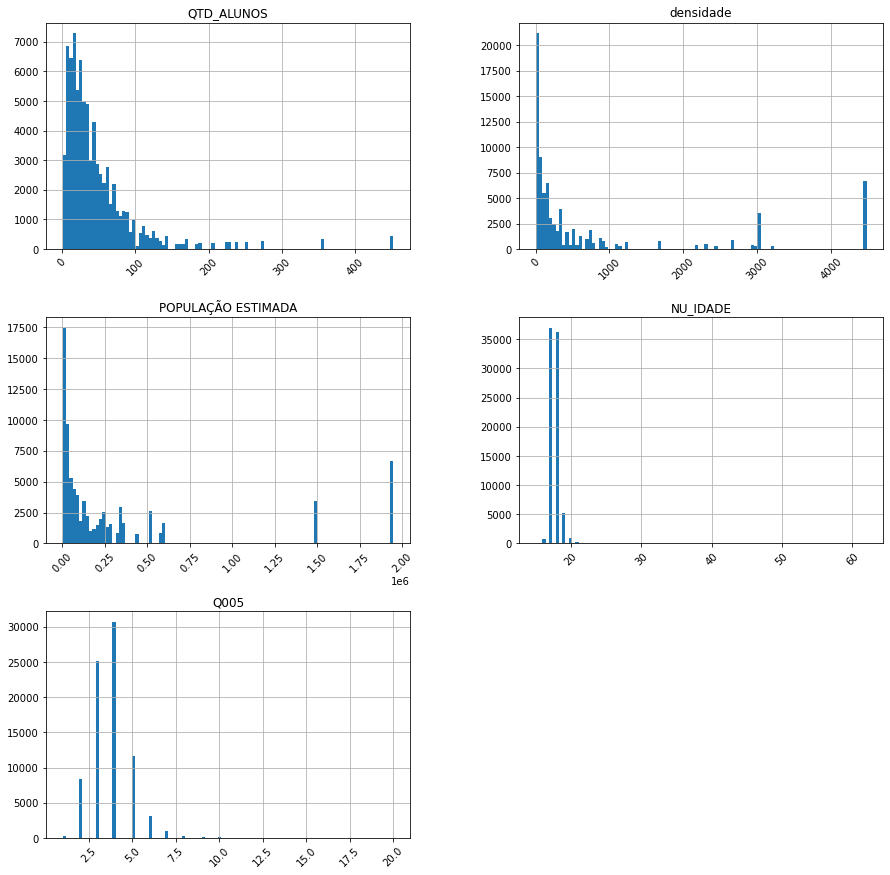

In [519]:
df_train[num_cols_updated].hist(figsize = (15,15),bins = 100, xrot = 45)
plt.show

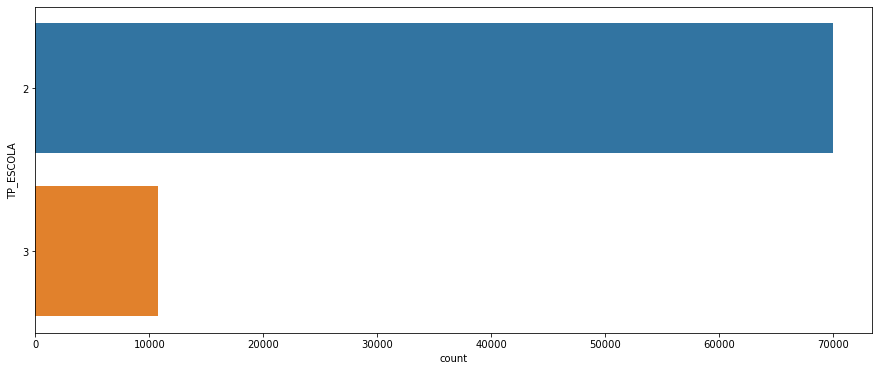

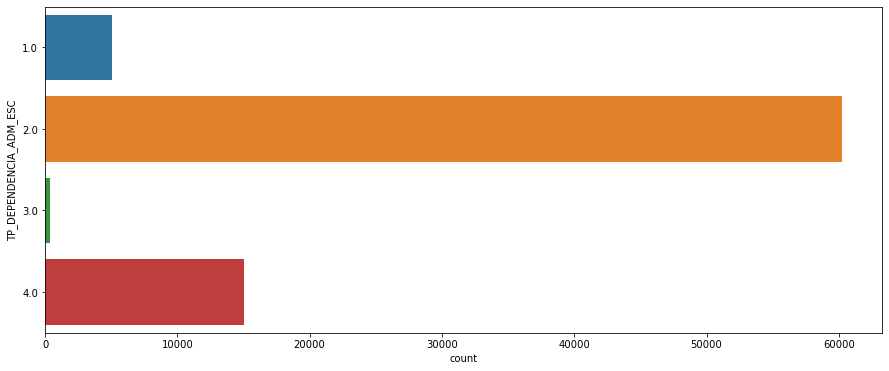

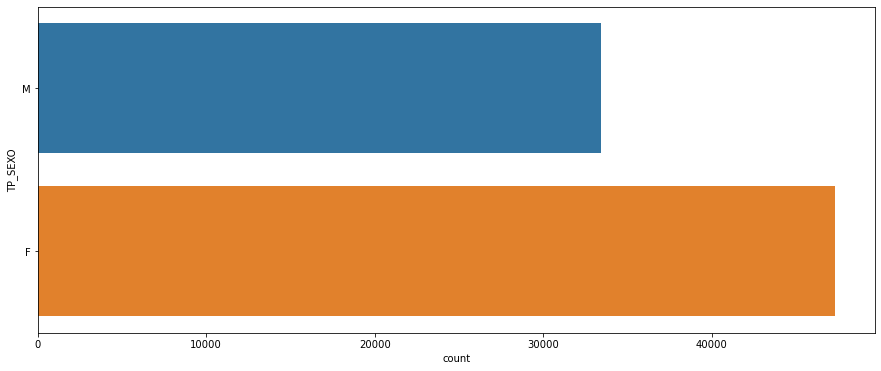

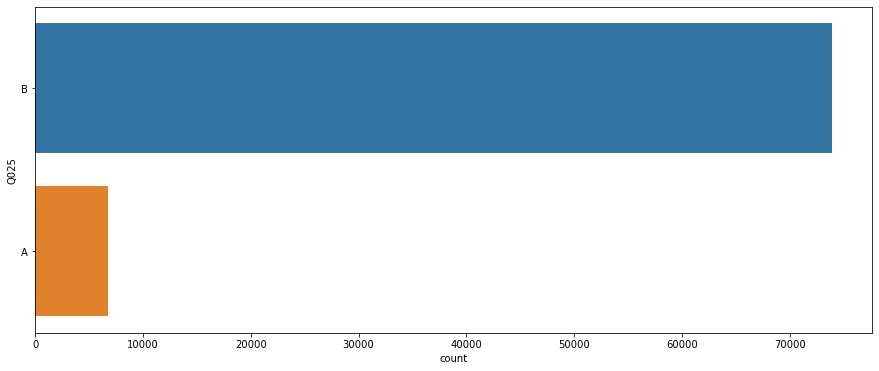

In [520]:
for x in df_train[cat_cols_updated]:
    fig, ax = plt.subplots(1, figsize=(15, 6))
    df_train[x] = df_train[x].astype("object")
    sns.countplot(y=x,data=df_train)
    plt.show

In [521]:
import string
string.ascii_uppercase
lista_ordem = list(string.ascii_uppercase)

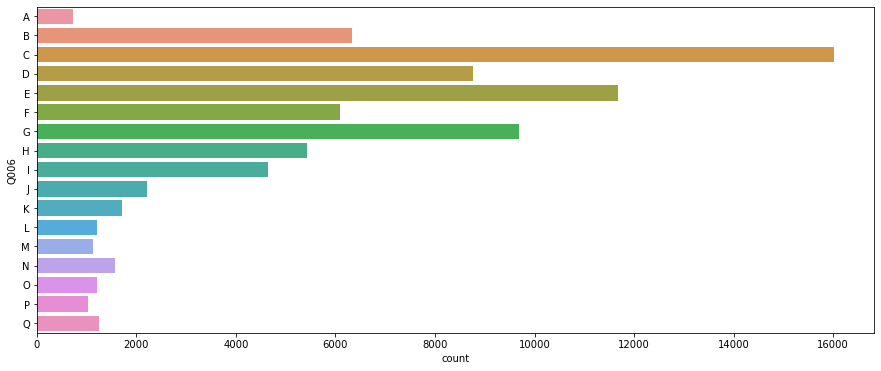

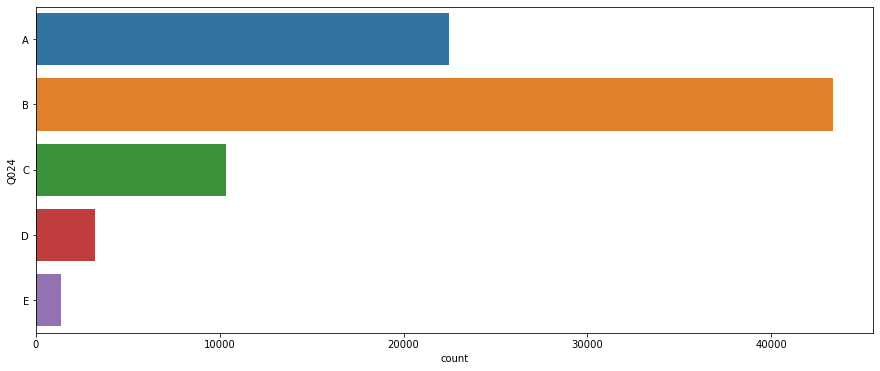

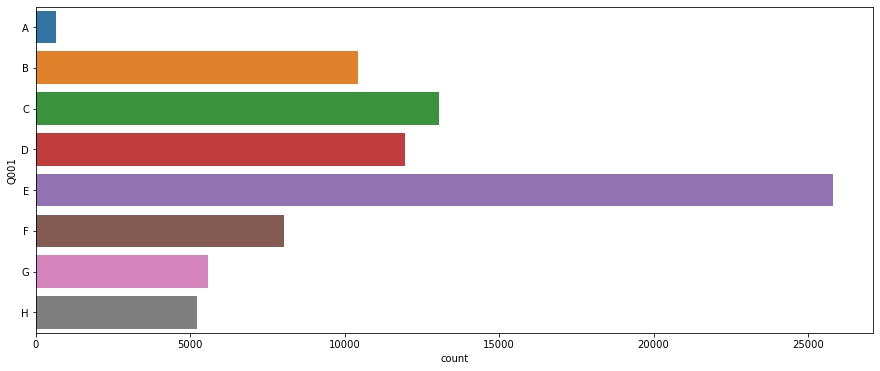

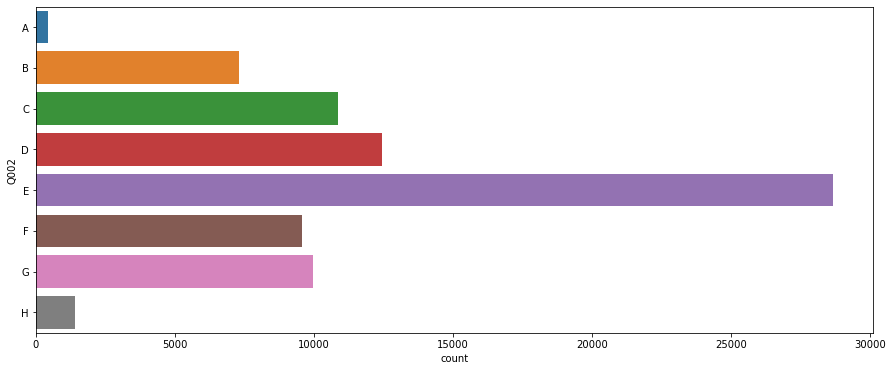

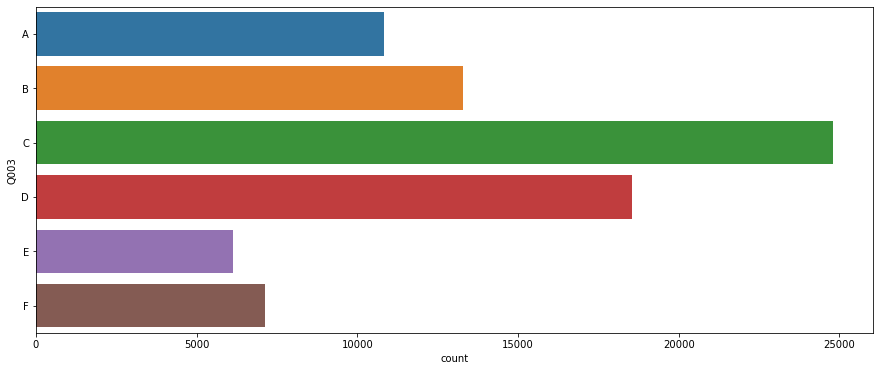

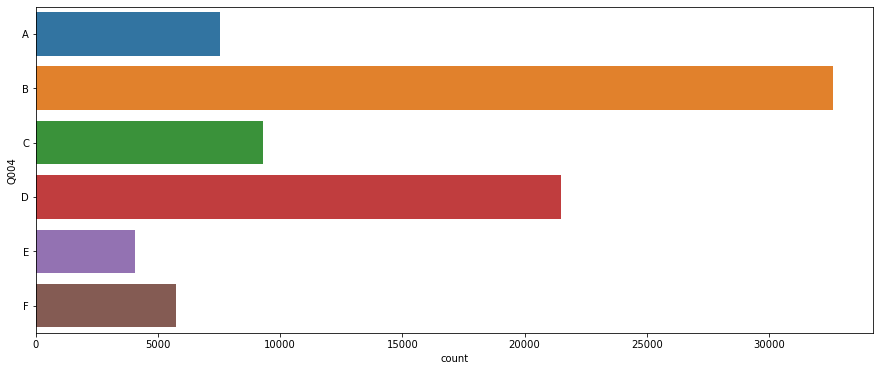

In [522]:
for x in df_train[ordinal_cols]:
    y = len(df_train[x].unique())
    fig, ax = plt.subplots(1, figsize=(15, 6))
    df_train[x] = df_train[x].astype("object")
    sns.countplot(y=x,order = lista_ordem[0:y],data=df_train)
    plt.show

In [523]:
for x in df_train[cat_cols_updated+ordinal_cols]:
    df_x = df_train[[x,"APROVADO"]]
    display(df_x.groupby("{}".format(x)).mean())

,APROVADO
TP_ESCOLA,
2,0.657453
3,0.939617


,APROVADO
TP_DEPENDENCIA_ADM_ESC,
1.0,0.941410
2.0,0.615686
3.0,0.668493
4.0,0.930744


,APROVADO
TP_SEXO,
F,0.663651
M,0.739436


,APROVADO
Q025,
A,0.494549
B,0.713432


,APROVADO
Q006,
A,0.479339
B,0.481370
C,0.565693
D,0.646449
E,0.659354
F,0.731779
G,0.747396
H,0.821297
I,0.826583


,APROVADO
Q024,
A,0.539003
B,0.715198
C,0.849347
D,0.912907
E,0.942378


,APROVADO
Q001,
A,0.441718
B,0.541599
C,0.619995
D,0.647640
E,0.740606
F,0.877057
G,0.904063
H,0.600230


,APROVADO
Q002,
A,0.383592
B,0.529742
C,0.586708
D,0.619743
E,0.713897
F,0.851863
G,0.859422
H,0.539437


,APROVADO
Q003,
A,0.588637
B,0.630807
C,0.653066
D,0.822099
E,0.913441
F,0.604129


,APROVADO
Q004,
A,0.581818
B,0.630066
C,0.665230
D,0.817763
E,0.917180
F,0.644278


In [524]:
df_train["Q003"].replace({"F":"C","C":"D","D":"E","E":"F"},inplace = True)
df_train["Q004"].replace({"F":"C","C":"D","D":"E","E":"F"},inplace = True)
df_test["Q003"].replace({"F":"C","C":"D","D":"E","E":"F"},inplace = True)
df_test["Q004"].replace({"F":"C","C":"D","D":"E","E":"F"},inplace = True)

In [525]:
df_train["Q001"].replace({"F":"C","C":"D","D":"E","E":"F"},inplace = True)
df_train["Q002"].replace({"F":"C","C":"D","D":"E","E":"F"},inplace = True)
df_test["Q001"].replace({"F":"C","C":"D","D":"E","E":"F"},inplace = True)
df_test["Q002"].replace({"F":"C","C":"D","D":"E","E":"F"},inplace = True)

In [526]:
df_train.groupby("Q003").mean()

,APROVADO,NU_IDADE,TP_ESTADO_CIVIL,TP_ENSINO,TP_LOCALIZACAO_ESC,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,Q005,QTD_ALUNOS,densidade,POPULAÇÃO ESTIMADA
Q003,,,,,,,,,,,
A,0.588637,17.708360,0.991039,1.001663,1.127206,0.001109,0.000370,3.812194,30.538661,138.672457,71389.947621
B,0.630807,17.746504,0.996843,1.002105,1.020598,0.001278,0.000376,3.781912,49.876635,895.245360,376737.925801
C,0.604129,17.804522,0.990872,1.002106,1.023452,0.000983,0.000421,3.593456,49.095633,914.093494,389386.702710
D,0.653066,17.704995,0.997823,1.002500,1.022134,0.000806,0.000323,3.813410,47.519010,696.637969,286408.990243
E,0.822099,17.542817,0.992558,1.001833,1.017849,0.000431,0.000162,3.739215,54.511702,1026.778840,440799.466620
F,0.913441,17.430345,0.997387,1.001470,1.009472,0.000327,0.000327,3.703903,65.465131,1479.802538,665805.536665


In [527]:
corrs = df_train[num_cols_updated+target].corr(method = "spearman")
corrs

,QTD_ALUNOS,densidade,POPULAÇÃO ESTIMADA,NU_IDADE,Q005,APROVADO
QTD_ALUNOS,1.000000,0.323491,0.331852,0.046179,-0.024212,0.132466
densidade,0.323491,1.000000,0.844755,-0.000467,-0.013930,0.129600
POPULAÇÃO ESTIMADA,0.331852,0.844755,1.000000,-0.004895,-0.010983,0.128542
NU_IDADE,0.046179,-0.000467,-0.004895,1.000000,-0.018589,-0.100397
Q005,-0.024212,-0.013930,-0.010983,-0.018589,1.000000,-0.049475
APROVADO,0.132466,0.129600,0.128542,-0.100397,-0.049475,1.000000


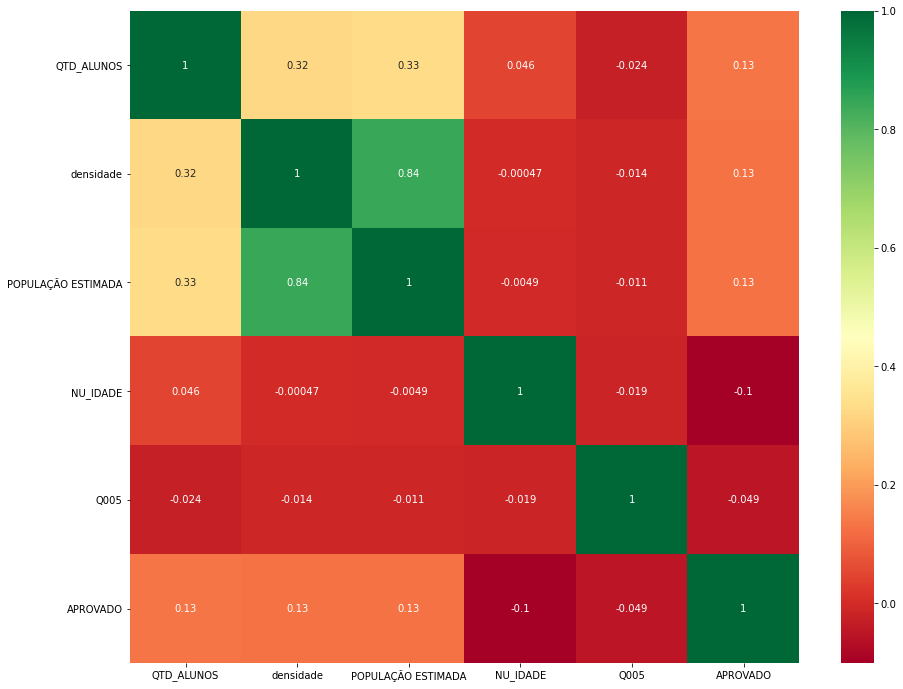

In [528]:
plt.figure(figsize = (15,12))
sns.heatmap(corrs, cmap="RdYlGn", annot = True)
plt.show()

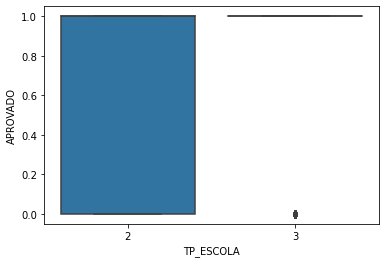

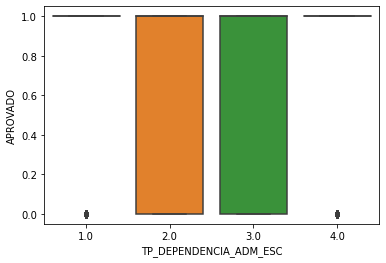

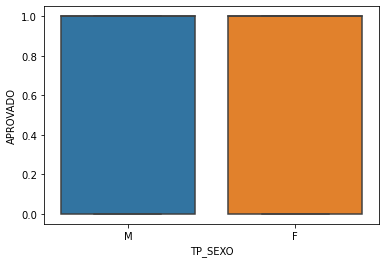

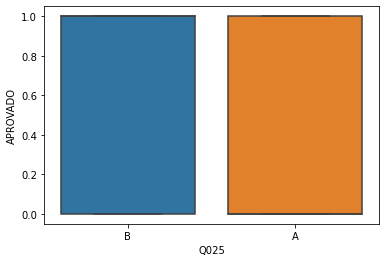

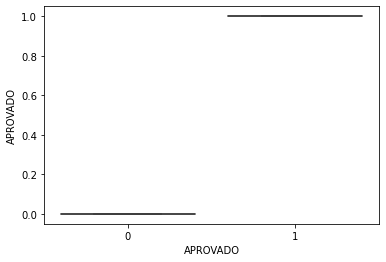

In [529]:
for a in df_train[cat_cols_updated+target]:
    sns.boxplot(y="APROVADO", x=a , data=df_train[cat_cols_updated+target])
    plt.show()

In [530]:
X_train

,NU_IDADE,TP_SEXO,TP_ESCOLA,TP_DEPENDENCIA_ADM_ESC,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025,QTD_ALUNOS,densidade,POPULAÇÃO ESTIMADA,tamanho_pop
0,18,M,2,4,H,E,F,D,4,C,B,B,31,3004.202749,1488252,5
1,19,M,2,4,H,B,B,B,5,C,A,B,31,3004.202749,1488252,5
2,18,M,2,4,H,H,B,F,7,B,A,A,31,3004.202749,1488252,5
3,19,F,2,4,B,B,C,B,3,C,A,B,31,3004.202749,1488252,5
4,20,M,2,4,H,E,C,B,3,D,A,A,31,3004.202749,1488252,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80713,17,F,2,2,C,C,A,A,5,F,B,B,1,15.306268,1614,1
80714,18,F,2,2,B,E,A,A,4,E,B,A,1,13.793878,982,1
80715,18,F,2,2,D,F,C,D,4,H,C,B,2,8.524330,1118,1
80716,18,M,2,2,D,C,A,A,7,C,A,B,2,8.524330,1118,1


#  PRÉ-PROCESSAMENTO

TENTATIVA PIPELINE

In [531]:
transformar_cat = ("one_hot_encoder",OneHotEncoder(handle_unknown = "ignore"),cat_cols_updated)
#transformar_numericas = ("quantile_transformer",QuantileTransformer(),num_cols_updated)
transformar_numericas = ("Robust_Scaler",RobustScaler(),num_cols_updated)
transformar_ordinais = ("ordinal_encoder",OrdinalEncoder(),ordinal_cols)
#transformar_label = ("label_encoder",LabelEncoder(),label_cols)

In [532]:
lista_transformacao = [transformar_cat,transformar_numericas,transformar_ordinais]
#lista_transformacao = [transformar_cat,transformar_numericas]

In [533]:
pipe_transformers = ColumnTransformer(lista_transformacao)

In [534]:
pipeline_enem = Pipeline([("transformar_colunas",pipe_transformers),("model",DecisionTreeClassifier())])

In [535]:
#pipe_sgd = Pipeline([('scl', RobustScaler()),("printar",print("cv"))])
#scaler = pipe_sgd.named_steps['scl'].fit_transform(df)

pipeline named_steps.transform

In [536]:
cv_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [537]:
#lista metricas de erro

In [538]:
# Fazendo validação cruzada
cv_scores_dt = cross_validate(
    estimator=pipeline_enem,
    X=X_train,
    y=y_train,
    scoring='neg_log_loss',
    cv=cv_skf,
    return_train_score=True
)

In [539]:
print(f'Log Loss no Treino: {-np.mean(cv_scores_dt["train_score"]):.4f}')
print(f'Log Loss no Teste: {-np.mean(cv_scores_dt["test_score"]):.4f}')

Log Loss no Treino: 0.0009
Log Loss no Teste: 12.2927


In [540]:
features_boruta

['NU_IDADE',
 'TP_SEXO',
 'TP_ESCOLA',
 'TP_DEPENDENCIA_ADM_ESC',
 'Q001',
 'Q002',
 'Q003',
 'Q004',
 'Q005',
 'Q006',
 'Q024',
 'Q025',
 'QTD_ALUNOS',
 'densidade',
 'POPULAÇÃO ESTIMADA',
 'tamanho_pop']

In [541]:
# Separa os dados de teste em X_test e y_test
X_test = df_test.loc[:, features_boruta]
y_test = df_test['APROVADO']
#X_train = df_train.loc[:, selected_features]
#y_train= df_train['FAIXA_MEDIAS']

In [542]:
X_test

,NU_IDADE,TP_SEXO,TP_ESCOLA,TP_DEPENDENCIA_ADM_ESC,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025,QTD_ALUNOS,densidade,POPULAÇÃO ESTIMADA,tamanho_pop
0,17,M,2,1.0,C,F,E,B,4,I,C,B,44,56.298832,16184,1
1,18,M,2,1.0,E,E,D,A,4,E,B,B,44,56.298832,16184,1
2,18,M,2,1.0,D,D,A,A,3,I,B,B,44,56.298832,16184,1
3,18,M,2,1.0,D,F,C,E,3,G,C,B,44,56.298832,16184,1
4,18,M,2,1.0,E,F,E,E,2,E,C,B,44,56.298832,16184,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20078,18,M,2,2.0,D,E,D,D,7,H,B,B,4,76.685236,11260,1
20079,18,F,2,2.0,D,E,B,B,3,B,A,B,3,3.590727,2886,1
20080,18,M,2,2.0,D,H,A,B,6,G,B,B,1,10.800348,1674,1
20081,17,M,2,2.0,B,B,D,A,3,F,A,B,9,18.978251,2973,1


In [543]:
X_train

,NU_IDADE,TP_SEXO,TP_ESCOLA,TP_DEPENDENCIA_ADM_ESC,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025,QTD_ALUNOS,densidade,POPULAÇÃO ESTIMADA,tamanho_pop
0,18,M,2,4,H,E,F,D,4,C,B,B,31,3004.202749,1488252,5
1,19,M,2,4,H,B,B,B,5,C,A,B,31,3004.202749,1488252,5
2,18,M,2,4,H,H,B,F,7,B,A,A,31,3004.202749,1488252,5
3,19,F,2,4,B,B,C,B,3,C,A,B,31,3004.202749,1488252,5
4,20,M,2,4,H,E,C,B,3,D,A,A,31,3004.202749,1488252,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80713,17,F,2,2,C,C,A,A,5,F,B,B,1,15.306268,1614,1
80714,18,F,2,2,B,E,A,A,4,E,B,A,1,13.793878,982,1
80715,18,F,2,2,D,F,C,D,4,H,C,B,2,8.524330,1118,1
80716,18,M,2,2,D,C,A,A,7,C,A,B,2,8.524330,1118,1


In [582]:
print(num_cols_updated)

['QTD_ALUNOS', 'densidade', 'tamanho_pop', 'POPULAÇÃO ESTIMADA', 'NU_IDADE', 'Q005']


In [583]:
param_grid_dt = {
    'model__criterion' : ['gini', 'entropy'],
    'model__max_depth' : range(5, 25),
    'model__min_samples_leaf' : range(2, 21, 2),
    'model__min_samples_split' : range(2, 41, 5),
}

random_search_dt = RandomizedSearchCV(
    estimator=pipeline_enem,
    param_distributions=param_grid_dt,
    scoring='neg_log_loss',
    random_state=123,
    n_jobs=-1,
    verbose=1,
    n_iter=300
)

random_search_dt.fit(X_train, y_train);

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  4.3min finished


In [584]:
print(f'Melhor Score do Decision Tree: {-random_search_dt.best_score_:.4f}')

Melhor Score do Decision Tree: 2.8028


In [585]:
teste = random_search_dt.best_params_

In [586]:
teste

{'model__min_samples_split': 17,
 'model__min_samples_leaf': 12,
 'model__max_depth': 5,
 'model__criterion': 'gini'}

In [587]:
X_train

,NU_IDADE,TP_SEXO,TP_ESCOLA,TP_DEPENDENCIA_ADM_ESC,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025,QTD_ALUNOS,densidade,POPULAÇÃO ESTIMADA,tamanho_pop
0,18,M,2,4,H,E,F,D,4,C,B,B,31,3004.202749,1488252,5
1,19,M,2,4,H,B,B,B,5,C,A,B,31,3004.202749,1488252,5
2,18,M,2,4,H,H,B,F,7,B,A,A,31,3004.202749,1488252,5
3,19,F,2,4,B,B,C,B,3,C,A,B,31,3004.202749,1488252,5
4,20,M,2,4,H,E,C,B,3,D,A,A,31,3004.202749,1488252,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80713,17,F,2,2,C,C,A,A,5,F,B,B,1,15.306268,1614,1
80714,18,F,2,2,B,E,A,A,4,E,B,A,1,13.793878,982,1
80715,18,F,2,2,D,F,C,D,4,H,C,B,2,8.524330,1118,1
80716,18,M,2,2,D,C,A,A,7,C,A,B,2,8.524330,1118,1


In [588]:
au0 = []
au1 = []
for x in y_train:
    if x == 0:
        au0.append(0)
    else:
        au1.append(1)

In [589]:
len(au1)

56101

In [590]:
X_train

,NU_IDADE,TP_SEXO,TP_ESCOLA,TP_DEPENDENCIA_ADM_ESC,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025,QTD_ALUNOS,densidade,POPULAÇÃO ESTIMADA,tamanho_pop
0,18,M,2,4,H,E,F,D,4,C,B,B,31,3004.202749,1488252,5
1,19,M,2,4,H,B,B,B,5,C,A,B,31,3004.202749,1488252,5
2,18,M,2,4,H,H,B,F,7,B,A,A,31,3004.202749,1488252,5
3,19,F,2,4,B,B,C,B,3,C,A,B,31,3004.202749,1488252,5
4,20,M,2,4,H,E,C,B,3,D,A,A,31,3004.202749,1488252,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80713,17,F,2,2,C,C,A,A,5,F,B,B,1,15.306268,1614,1
80714,18,F,2,2,B,E,A,A,4,E,B,A,1,13.793878,982,1
80715,18,F,2,2,D,F,C,D,4,H,C,B,2,8.524330,1118,1
80716,18,M,2,2,D,C,A,A,7,C,A,B,2,8.524330,1118,1


In [591]:
X_test

,NU_IDADE,TP_SEXO,TP_ESCOLA,TP_DEPENDENCIA_ADM_ESC,Q001,Q002,Q003,Q004,Q005,Q006,Q024,Q025,QTD_ALUNOS,densidade,POPULAÇÃO ESTIMADA,tamanho_pop
0,17,M,2,1.0,C,F,E,B,4,I,C,B,44,56.298832,16184,1
1,18,M,2,1.0,E,E,D,A,4,E,B,B,44,56.298832,16184,1
2,18,M,2,1.0,D,D,A,A,3,I,B,B,44,56.298832,16184,1
3,18,M,2,1.0,D,F,C,E,3,G,C,B,44,56.298832,16184,1
4,18,M,2,1.0,E,F,E,E,2,E,C,B,44,56.298832,16184,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20078,18,M,2,2.0,D,E,D,D,7,H,B,B,4,76.685236,11260,1
20079,18,F,2,2.0,D,E,B,B,3,B,A,B,3,3.590727,2886,1
20080,18,M,2,2.0,D,H,A,B,6,G,B,B,1,10.800348,1674,1
20081,17,M,2,2.0,B,B,D,A,3,F,A,B,9,18.978251,2973,1


In [592]:
best_dt = random_search_dt.best_estimator_
y_pred_dt = best_dt.predict_proba(X_test)
print(f'Log Loss de Descision Tree no Teste {log_loss(y_test, y_pred_dt):.4f}')

Log Loss de Descision Tree no Teste 0.5332


In [593]:
# Calcula predicao do modelo
yhat = best_dt.predict(X_test)

In [594]:
yhat

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [619]:
# Porcentagem de classificações corretas
print('Acurácia no treino:', best_dt.score(X_train, y_train))
print('Acurácia no teste:', accuracy_score(y_test, yhat))

Acurácia no treino: 0.7158750216804183
Acurácia no teste: 0.719563810187721


In [596]:
#625    Acurácia no treino: 0.866721177432543
#Acurácia no teste: 0.866454215007718
#PRECISION 0.6055979643765903
#RECALL 0.2436

550
Acurácia no treino: 0.7165811838747244
Acurácia no teste: 0.7144350943584126
precision:0.7731538870196565
recall:0.4950113378684807


500 Acurácia no treino: 0.7074877970217299 Acurácia no teste: 0.7081611313050838 precision:0.7117776152158011 recall:0.9752989188802177

In [620]:
# De todos os candidatos que o modelo disse que ficaram no último quantil, quantos realmente ficaram
precision_score(y_test, yhat, average="binary", pos_label = 1)

0.752438064086256

In [598]:
# De todos os candidatos que ficaram com a nota dentro do último quantil, quantos o modelo conseguiu identificar

recall_score(y_test, yhat, average="binary", pos_label = 1)

0.8893821149853225

In [599]:
teste

{'model__min_samples_split': 17,
 'model__min_samples_leaf': 12,
 'model__max_depth': 5,
 'model__criterion': 'gini'}

# APRESENTAÇÃO DO MODELO

In [600]:
from dtreeviz.trees import dtreeviz # remember to load the package

In [601]:
import graphviz

In [602]:
import sys
import os
# add library module to PYTHONPATH

sys.path.append(f"{os.getcwd()}/../")

In [603]:
from sklearn.datasets import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

In [604]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Users\eduar\anaconda3\envs\DH\Library\bin\graphviz'


CRIANDO A LISTA PARA IDENTIFICAR AS FEATURES

In [605]:
features = pipeline_enem.named_steps['transformar_colunas'].fit_transform(X_train)

In [606]:
features

array([[1., 0., 0., ..., 4., 5., 3.],
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 0., 0., ..., 7., 1., 5.],
       ...,
       [1., 0., 0., ..., 5., 2., 3.],
       [1., 0., 0., ..., 2., 0., 0.],
       [1., 0., 0., ..., 4., 1., 1.]])

In [607]:
aux = []
for x in X_train[cat_cols_updated]:
    print(x)
    
    for a in X_train[x].unique():
        print(a)
        aux.append("{}_{}".format(x,a))
        

TP_ESCOLA
2
3
TP_DEPENDENCIA_ADM_ESC
4.0
2.0
1.0
3.0
TP_SEXO
M
F
Q025
B
A


In [608]:
for col in num_cols_updated:
    aux.append(col)



In [609]:
for col in ordinal_cols:
    aux.append(col)


In [610]:
len(aux)

22

In [611]:
df_grafico = pd.DataFrame(features,columns = aux)

In [612]:
teste

{'model__min_samples_split': 17,
 'model__min_samples_leaf': 12,
 'model__max_depth': 5,
 'model__criterion': 'gini'}

In [613]:
lista = df_grafico.columns.tolist()

In [614]:
teste

{'model__min_samples_split': 17,
 'model__min_samples_leaf': 12,
 'model__max_depth': 5,
 'model__criterion': 'gini'}

In [637]:
len(legenda)

22

In [635]:
legenda = ["ENSINO MÉDIO EM ESCOLA PÚBLICA","ENSINO MÉDIO EM ESCOLA PRIVADA",
           "ADMINISTRAÇÃO DA ESCOLA - PRIVADA","ADMINISTRAÇÃO DA ESCOLA - ESTADUAL",
           "ADMINISTRAÇÃO DA ESCOLA - FEDERAL","ADMINISTRAÇÃO DA ESCOLA - MUNICIPAL",
           "MASCULINO","FEMININO", "RESIDÊNCIA POSSUI INTERNET","RESIDÊNCIA NÃO POSSUI INTERNET",
           "QUANTIDADE DE ALUNOS NA ESCOLA", "DENSIDADE DEMOGRÂFICA","QUANTIL TAMANHO POPULAÇÃO",
           "POPULAÇÃO ESTIMADA NO MUNICÍPIO","IDADE","QUANTAS PESSOAS MORAM NA RESIDÊNCIA","RENDA FAMILIAR",
           "QUANTOS COMPUTADORES POSSUI NA RESIDÊNCIA","ATÉ QUE SÉRIE O PAI ESTUDOU",
            "ATÉ QUE SÉRIE A MÃE ESTUDOU","PROFISSÃO PAI","PROFISSÃO MÃE"]

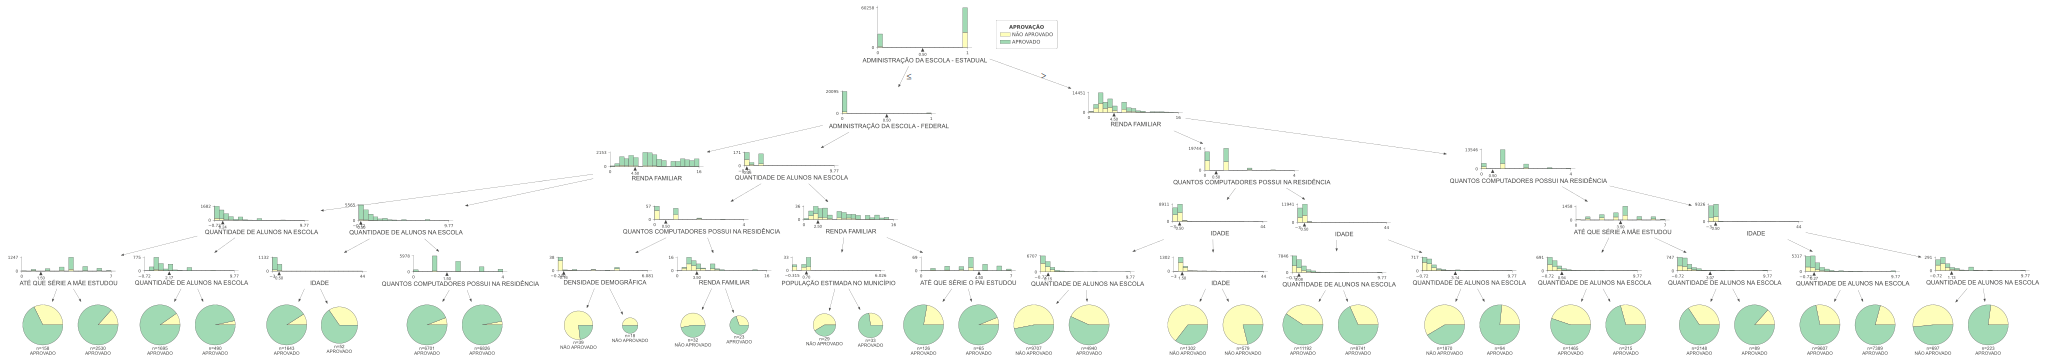

In [638]:
clas = DecisionTreeClassifier(min_samples_split =  17 ,min_samples_leaf = 12, max_depth = 5,criterion = "gini")  


#X_train = cancer.data
#y_train = cancer.target
clas.fit(df_grafico, y_train)

viz = dtreeviz(clas, 
               df_grafico,
               y_train,
               target_name='APROVAÇÃO',
               #feature_names=X_train.columns, 
               feature_names=legenda,
               class_names=["NÃO APROVADO", "APROVADO"])
               #,orientation='LR' )
viz



In [641]:
viz.save("ROBUST.svg")

COLOCAR O BEST PARAMS + O PIPELINE NA HORA DAS COLUNAS